In [1]:
# -*- coding: utf-8 -*-
# @Author   : 陈浩骏, 2017326603075
# Python Version == 3.8.5
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pylab as plot
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
%matplotlib inline
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150
sns.set(rc={"figure.dpi": 150, 'savefig.dpi': 150})
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

首次数据是从`kaggle`上直接下载下来的.
首次作业见[Assignment3 Page](https://mijazzchan.gitee.io/dataminingassignment/Assignment3/DataMiningAssignment3.html)

因下列block所依赖数据为`kaggle`上的原始数据, 而实际课程上作业拿到的数据是经过特意修改后的, 含有重复列和特殊值的.

故以下`block`专门对数据进行去重.

In [2]:
corruptedData = pd.read_csv('./CorruptedTitanic/train.csv')
corruptedData.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,892.000000,892.000000,892.000000,715.000000,892.000000,892.000000,892.000000
mean,445.547085,0.383408,2.308296,30.249189,0.523543,0.381166,195.705100
std,257.564835,0.486489,0.835666,20.038824,1.102240,0.805706,4887.636304
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,222.750000,0.000000,2.000000,20.750000,0.000000,0.000000,7.917700
50%,445.500000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.250000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,400.000000,8.000000,6.000000,146000.520800


很明显有些奇怪的东西混了进来

+ 891名乘客, 计数是892
+ 年龄有个最大值是400

In [3]:
corruptedData[corruptedData.duplicated()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Ethnicity,Cabin,Embarked
42,42,0,2,"Turpin, Mrs. William John Robert (Dorothy Ann ...",female,27.0,1,0,11668,21.0,white,NaN,S


即位于`PassengerId == 42`的列是重复列.

In [4]:
corruptedData.drop_duplicates(inplace=True)
corruptedData[corruptedData.duplicated()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Ethnicity,Cabin,Embarked


重复的现在被去掉了.

接下来处理年龄.


In [5]:
corruptedData[corruptedData['Age'] > 100]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Ethnicity,Cabin,Embarked
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,400.0,1,1,PP 9549,16.7,white,G6,S


`PassengerId == 11`出了一个400岁的.

拿掉, 平均数填充.

In [6]:
corruptedData.loc[corruptedData.PassengerId == 11] = corruptedData['Age'].mean
corruptedData.describe()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Ethnicity,Cabin,Embarked
count,891,891,891,891,891,714.0,891,891,891,891.00,891,204,889
unique,891,3,4,891,3,89.0,8,8,682,250.00,3,148,4
top,366,0,3,"Gheorgheff, Mr. Stanio",male,24.0,0,0,347082,8.05,white,B96 B98,S
freq,1,549,490,1,577,30.0,608,678,7,43.00,888,4,643


异常值处理完毕

In [7]:
trainData = pd.read_csv('./titanic/train.csv')
print(trainData.shape)
trainData.head(5)

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 完成依赖引入与数据读入.

> 如无特殊说明, 图例中绿色代表存活`Survived`, 红色代表不幸罹难`Perished`.

In [8]:
trainData.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


注意到`PassengerID.count == 891`, 而`Age.count == 714`, 即年龄缺失177个数据.
进行中位数/随机森林预测数据补充.

In [9]:
# Median Data
# trainData['AgeM'] = trainData['Age'].fillna(trainData['Age'].median)

# Random Forest Approach
age_df = trainData[['Age', 'Fare', 'Parch', 'SibSp', 'Pclass']]
age_df_notnull = age_df.loc[(trainData['Age'].notnull())]
age_df_isnull = age_df.loc[(trainData['Age'].isnull())]
X = age_df_notnull.values[:,1:]
Y = age_df_notnull.values[:,0]
RFR = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
RFR.fit(X,Y)
predictAges = RFR.predict(age_df_isnull.values[:,1:])
trainData.loc[trainData['Age'].isnull(), ['Age']]= predictAges

In [10]:
trainData['Age'].count()  # 为891即补充完整

891

## 关注性别
+ 基于生存人数(计数)的性别分布

In [11]:
# 加入新列: Perished -> 逝世(Boolean)
trainData['Perished'] = 1 - trainData['Survived']
trainData.groupby('Sex').agg('sum')[['Survived', 'Perished']]

,Survived,Perished
Sex,,
female,233,81
male,109,468


+ 基于生存人数(按比例)的性别分布

In [12]:
trainData.groupby('Sex').agg('mean')[['Survived', 'Perished']]

,Survived,Perished
Sex,,
female,0.742038,0.257962
male,0.188908,0.811092


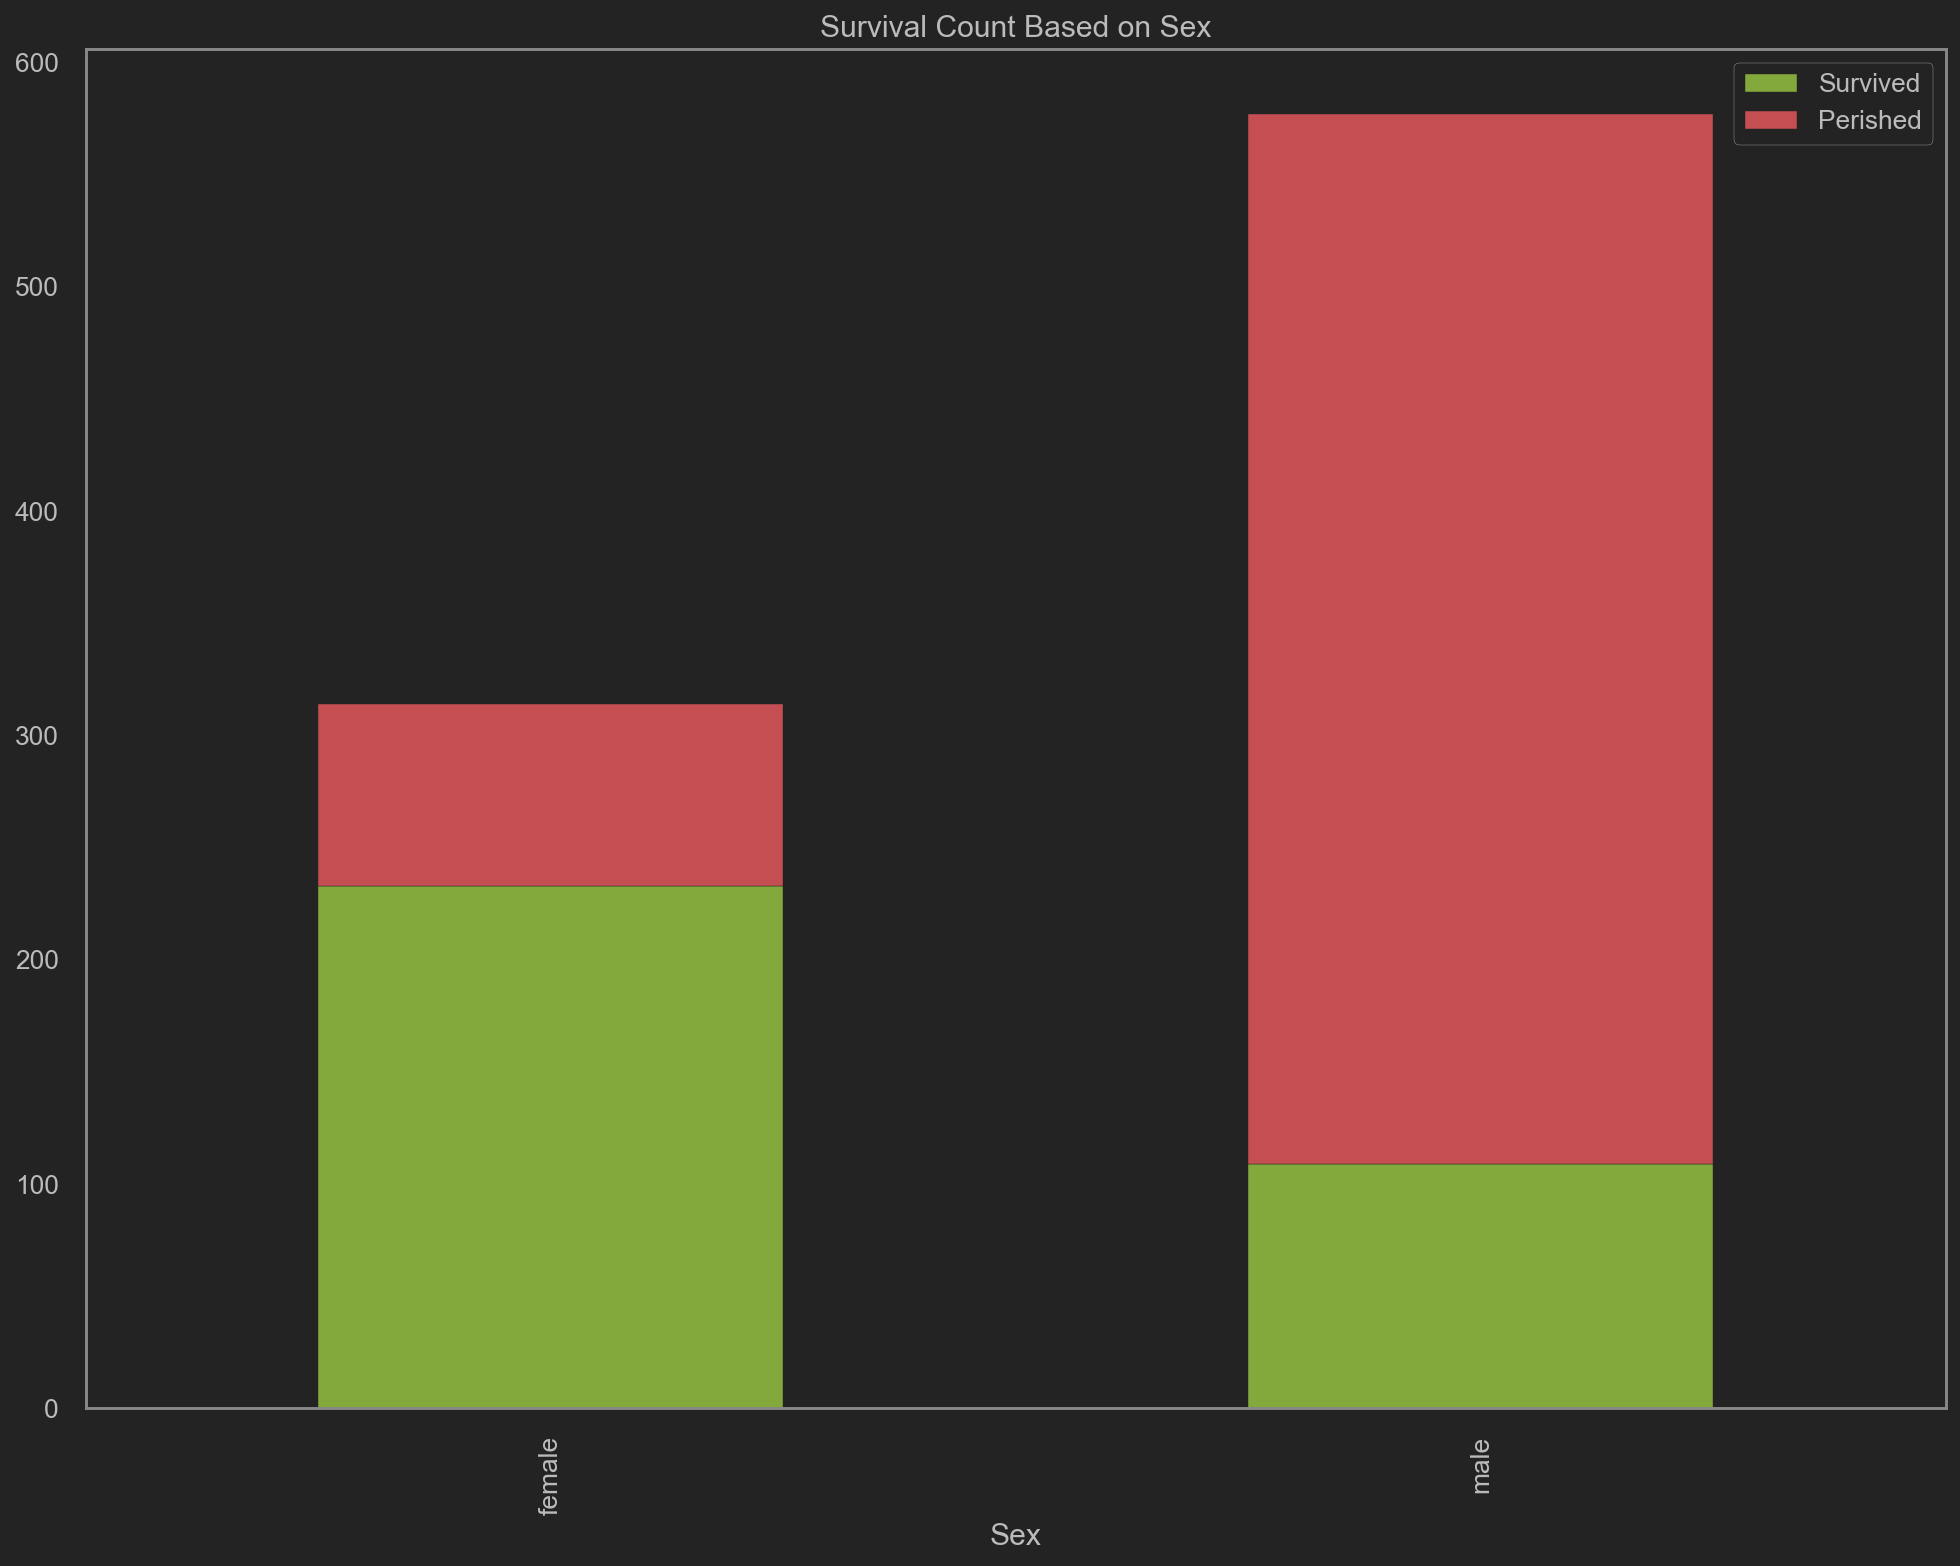

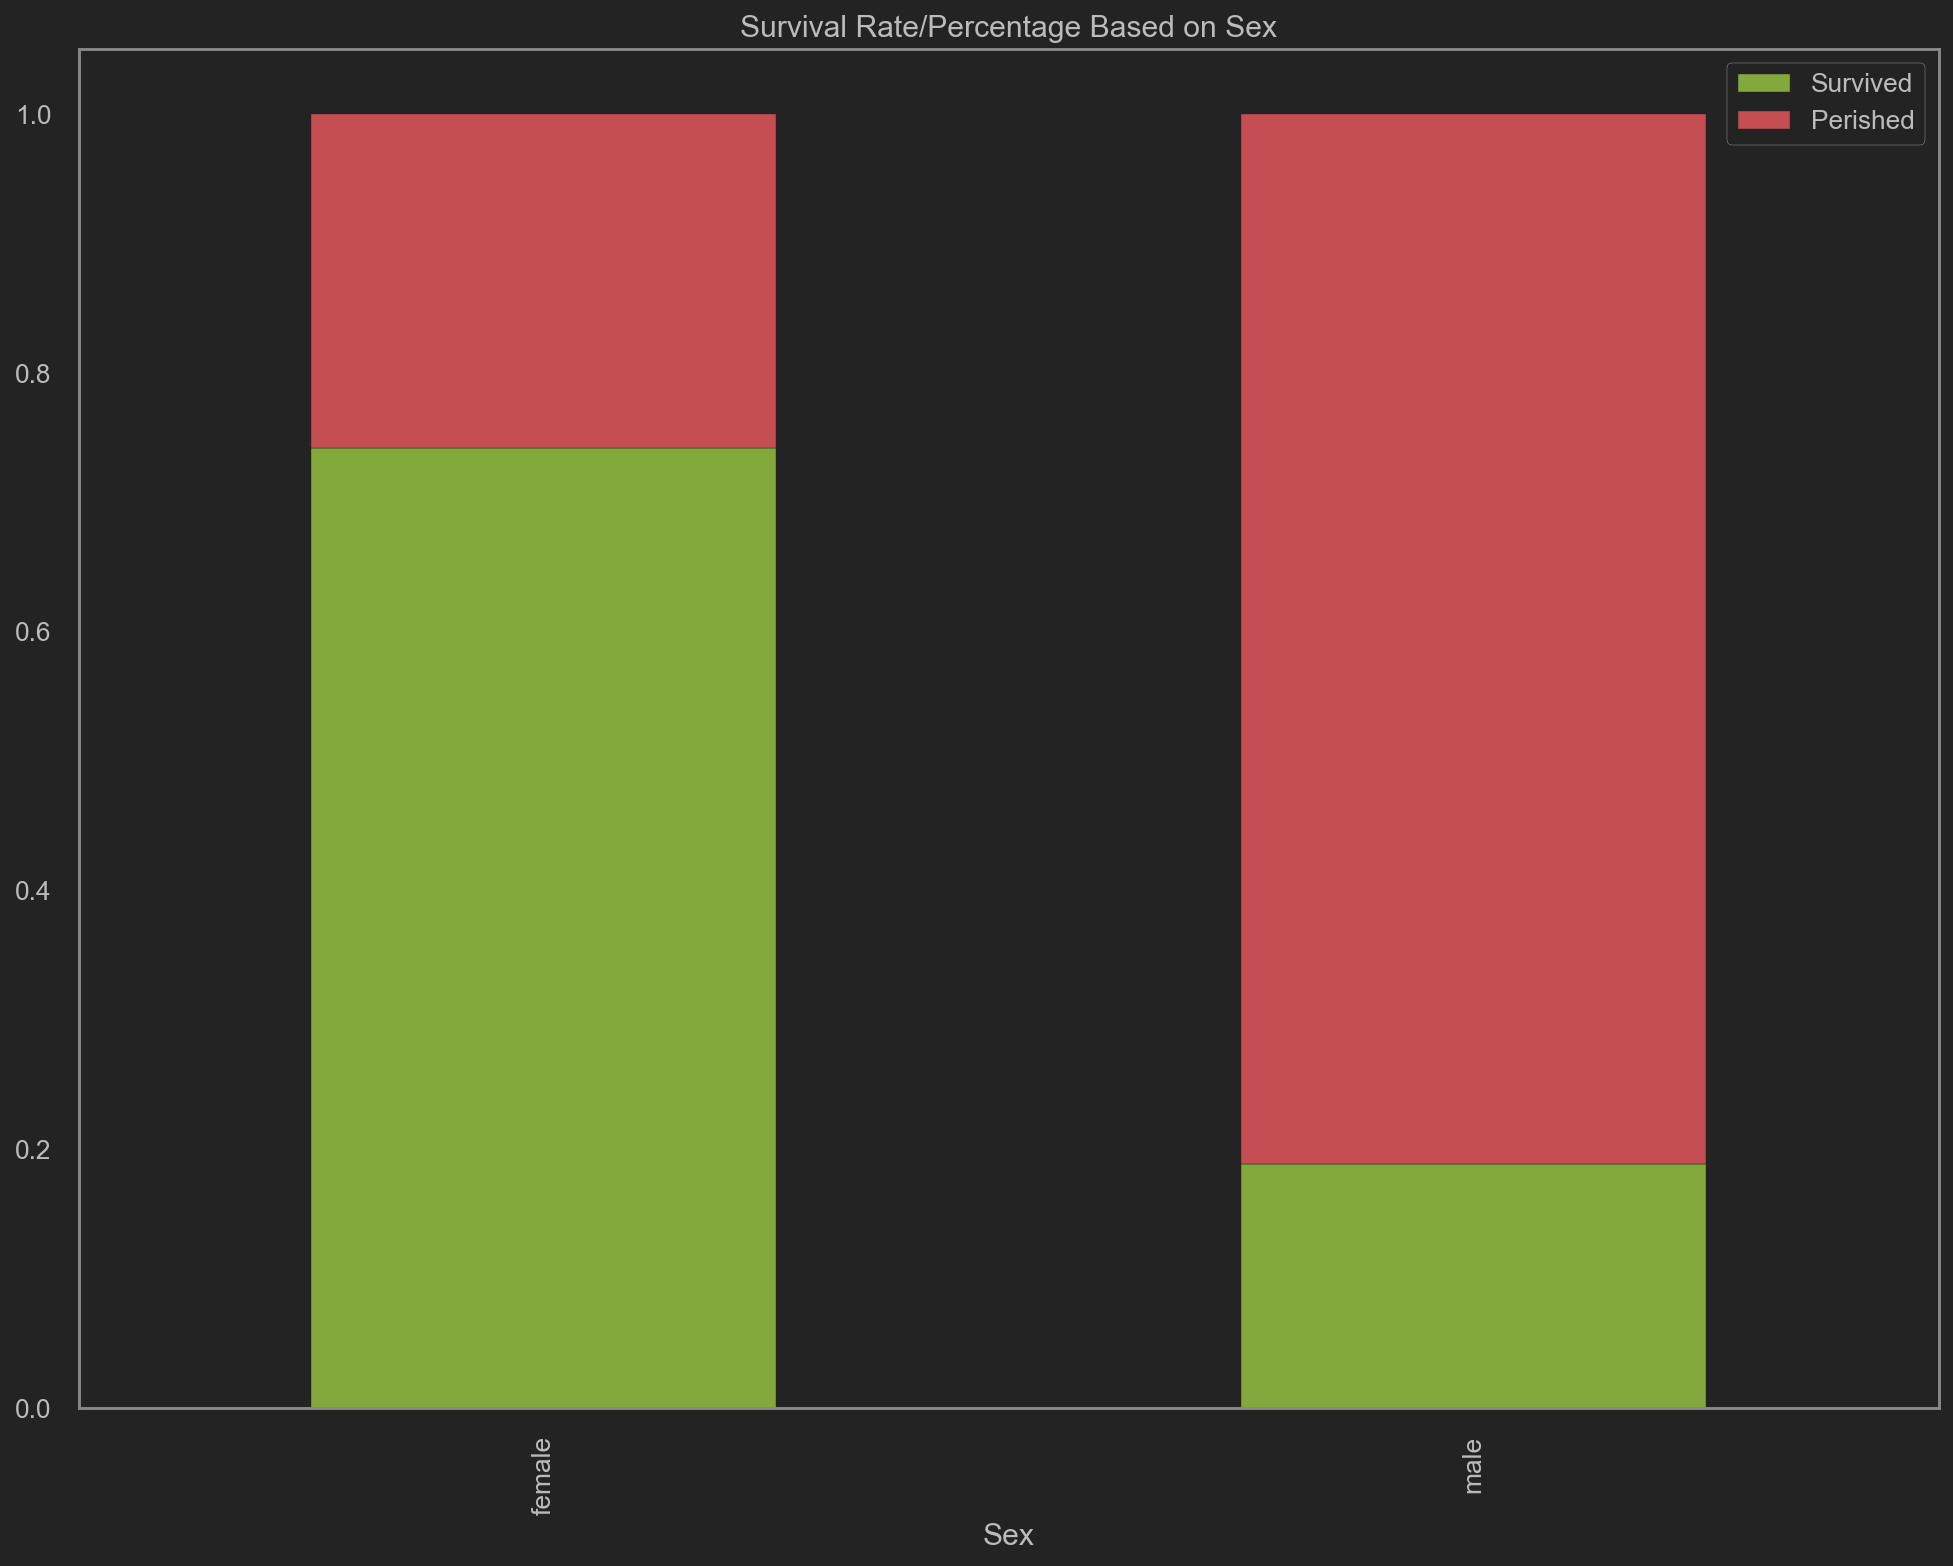

In [13]:
# 基于性别的死亡计数
trainData.groupby('Sex').agg('sum')[['Survived', 'Perished']] \
    .plot(kind='bar', stacked=True, color=['g', 'r'], title='Survival Count Based on Sex', figsize=(16, 12))
# 基于性别的死亡率计算
trainData.groupby('Sex').agg('mean')[['Survived', 'Perished']] \
    .plot(kind='bar', stacked=True, color=['g', 'r'], title='Survival Rate/Percentage Based on Sex', figsize=(16, 12))

不难看出, 在数据集中, `Age == Female`即女性的死亡率较低. 因此加入年龄作为参考因素, 绘制`violin graph`.

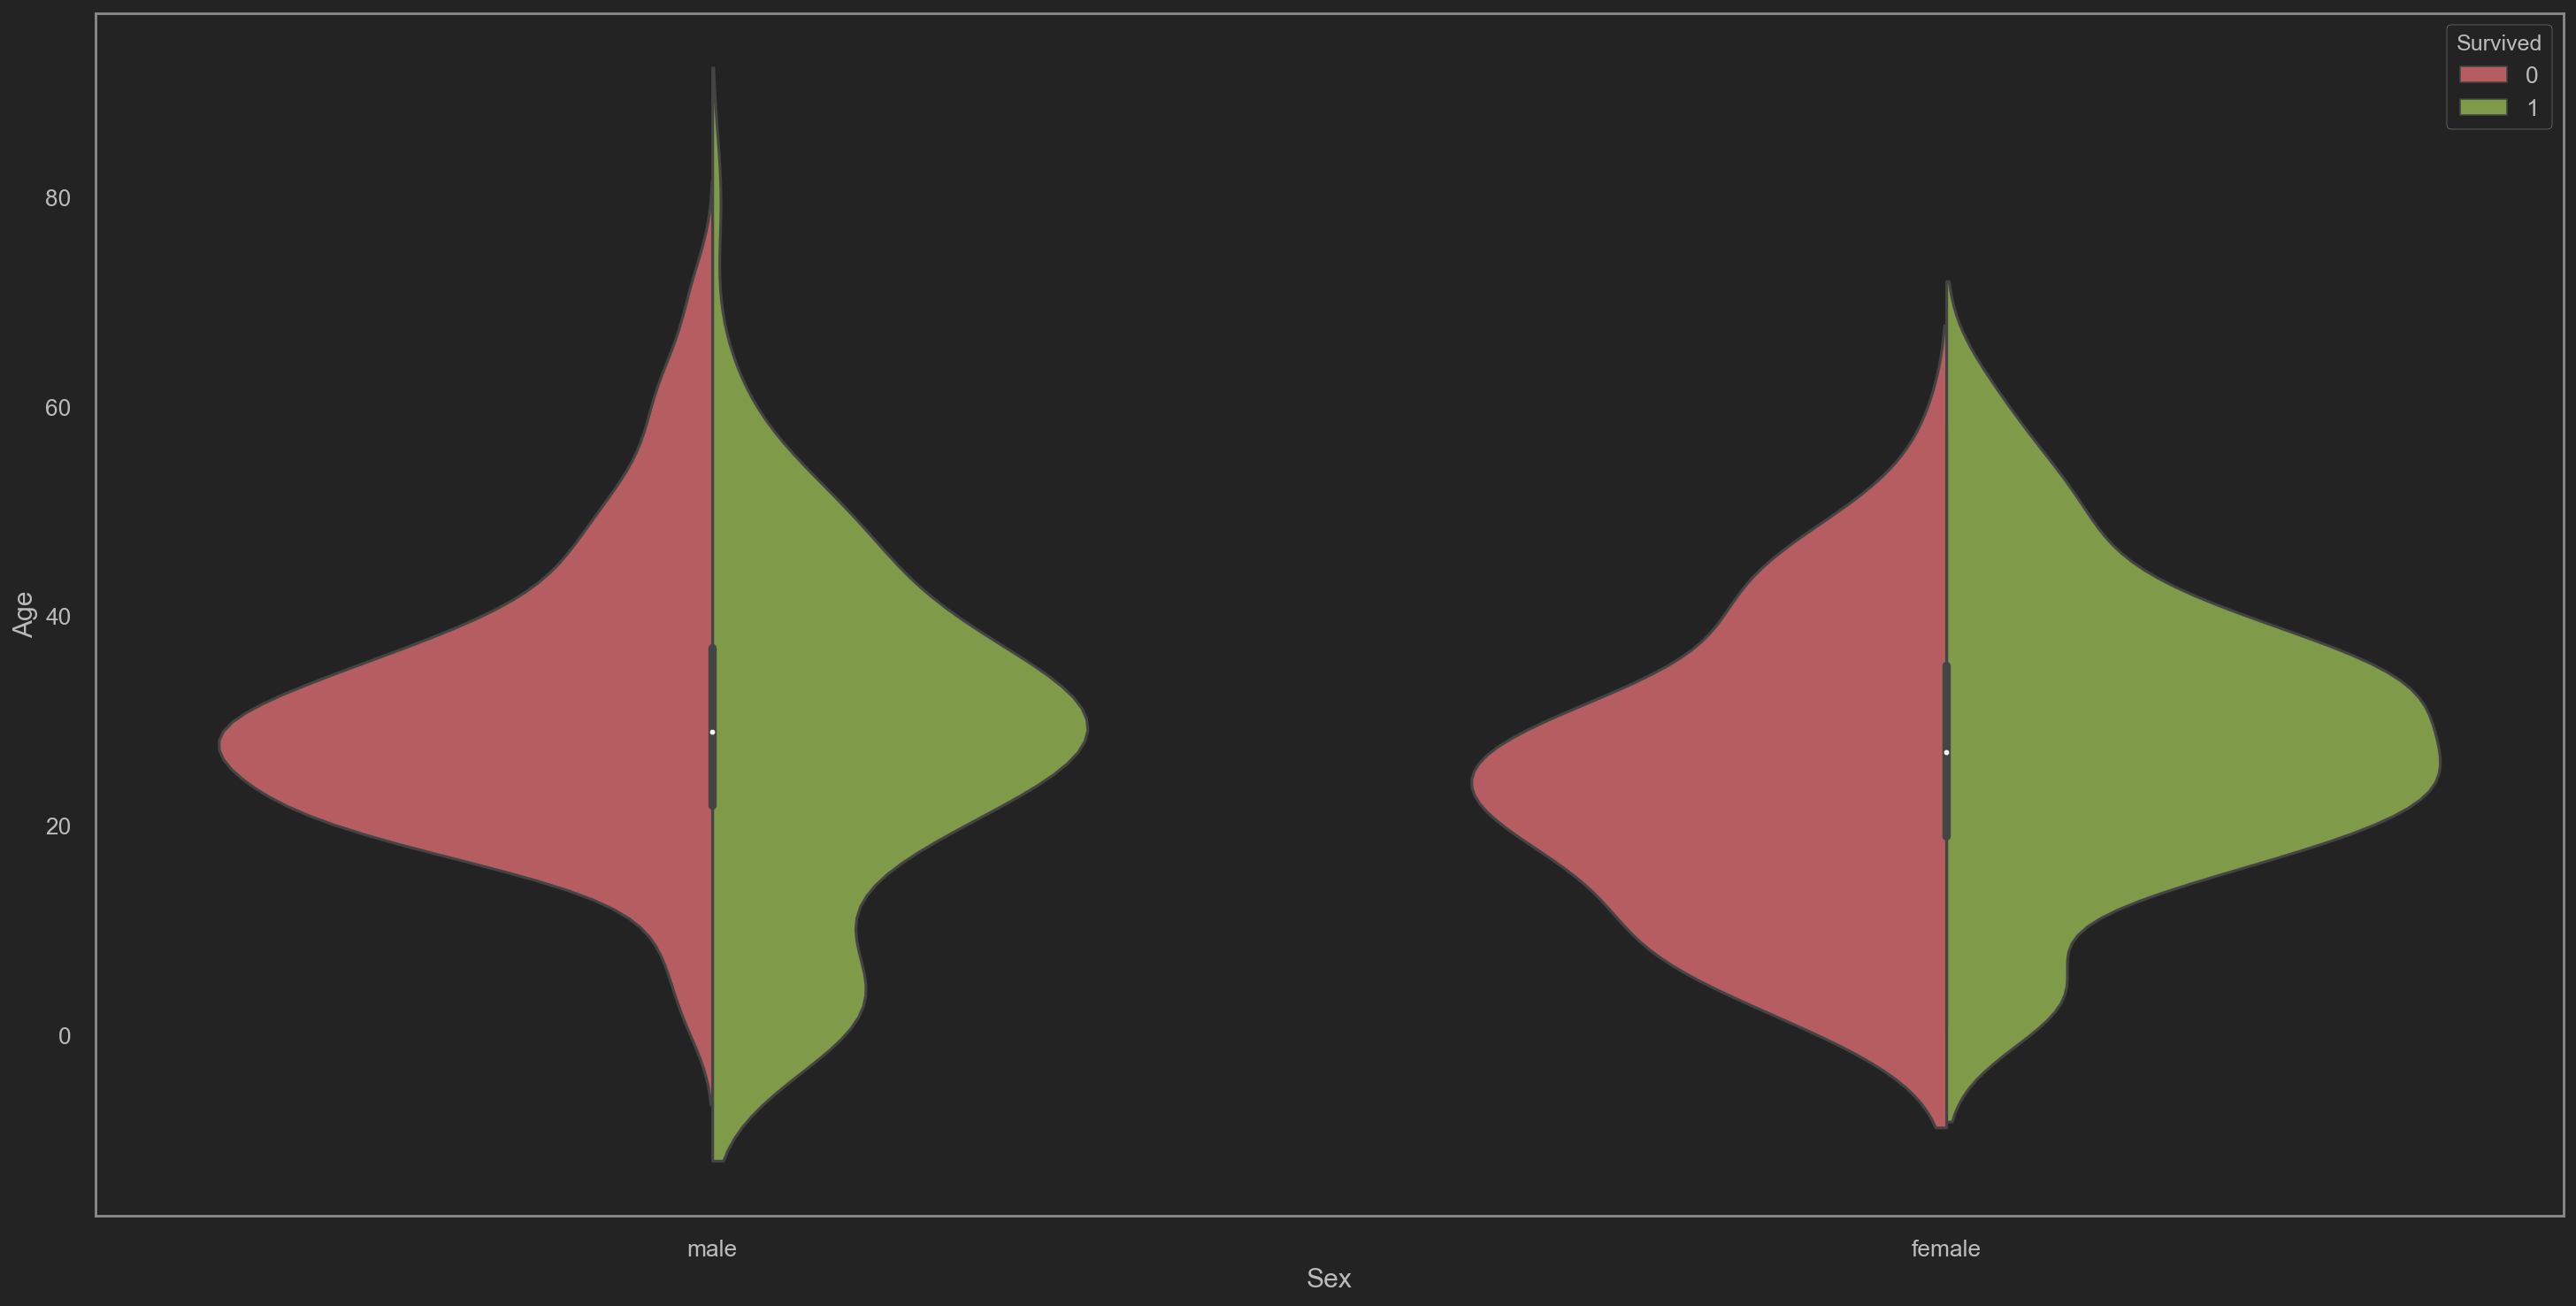

In [14]:
fig = plt.figure(figsize=(24, 12))
# 基于性别分类的存活率与死亡率的年龄分布小提琴图
sns.violinplot(x='Sex', y='Age', hue='Survived', data=trainData, 
               split=True, palette={0: "r", 1: "g"}, 
               title='Violin Plot on Survival Rate and Death Rate Based on Sex')

得到以下特征
+ 青少年男性存活比例较高, 而中年(Age~=30)男性死亡率高
+ 女性各年龄段存活比例相对平均

## 关注客舱等级(`Pclass`)

In [15]:
trainData.groupby('Pclass').agg('sum')[['Survived', 'Perished']]

,Survived,Perished
Pclass,,
1,136,80
2,87,97
3,119,372


In [16]:
trainData.groupby('Pclass').agg('mean')[['Survived', 'Perished']]

,Survived,Perished
Pclass,,
1,0.629630,0.370370
2,0.472826,0.527174
3,0.242363,0.757637


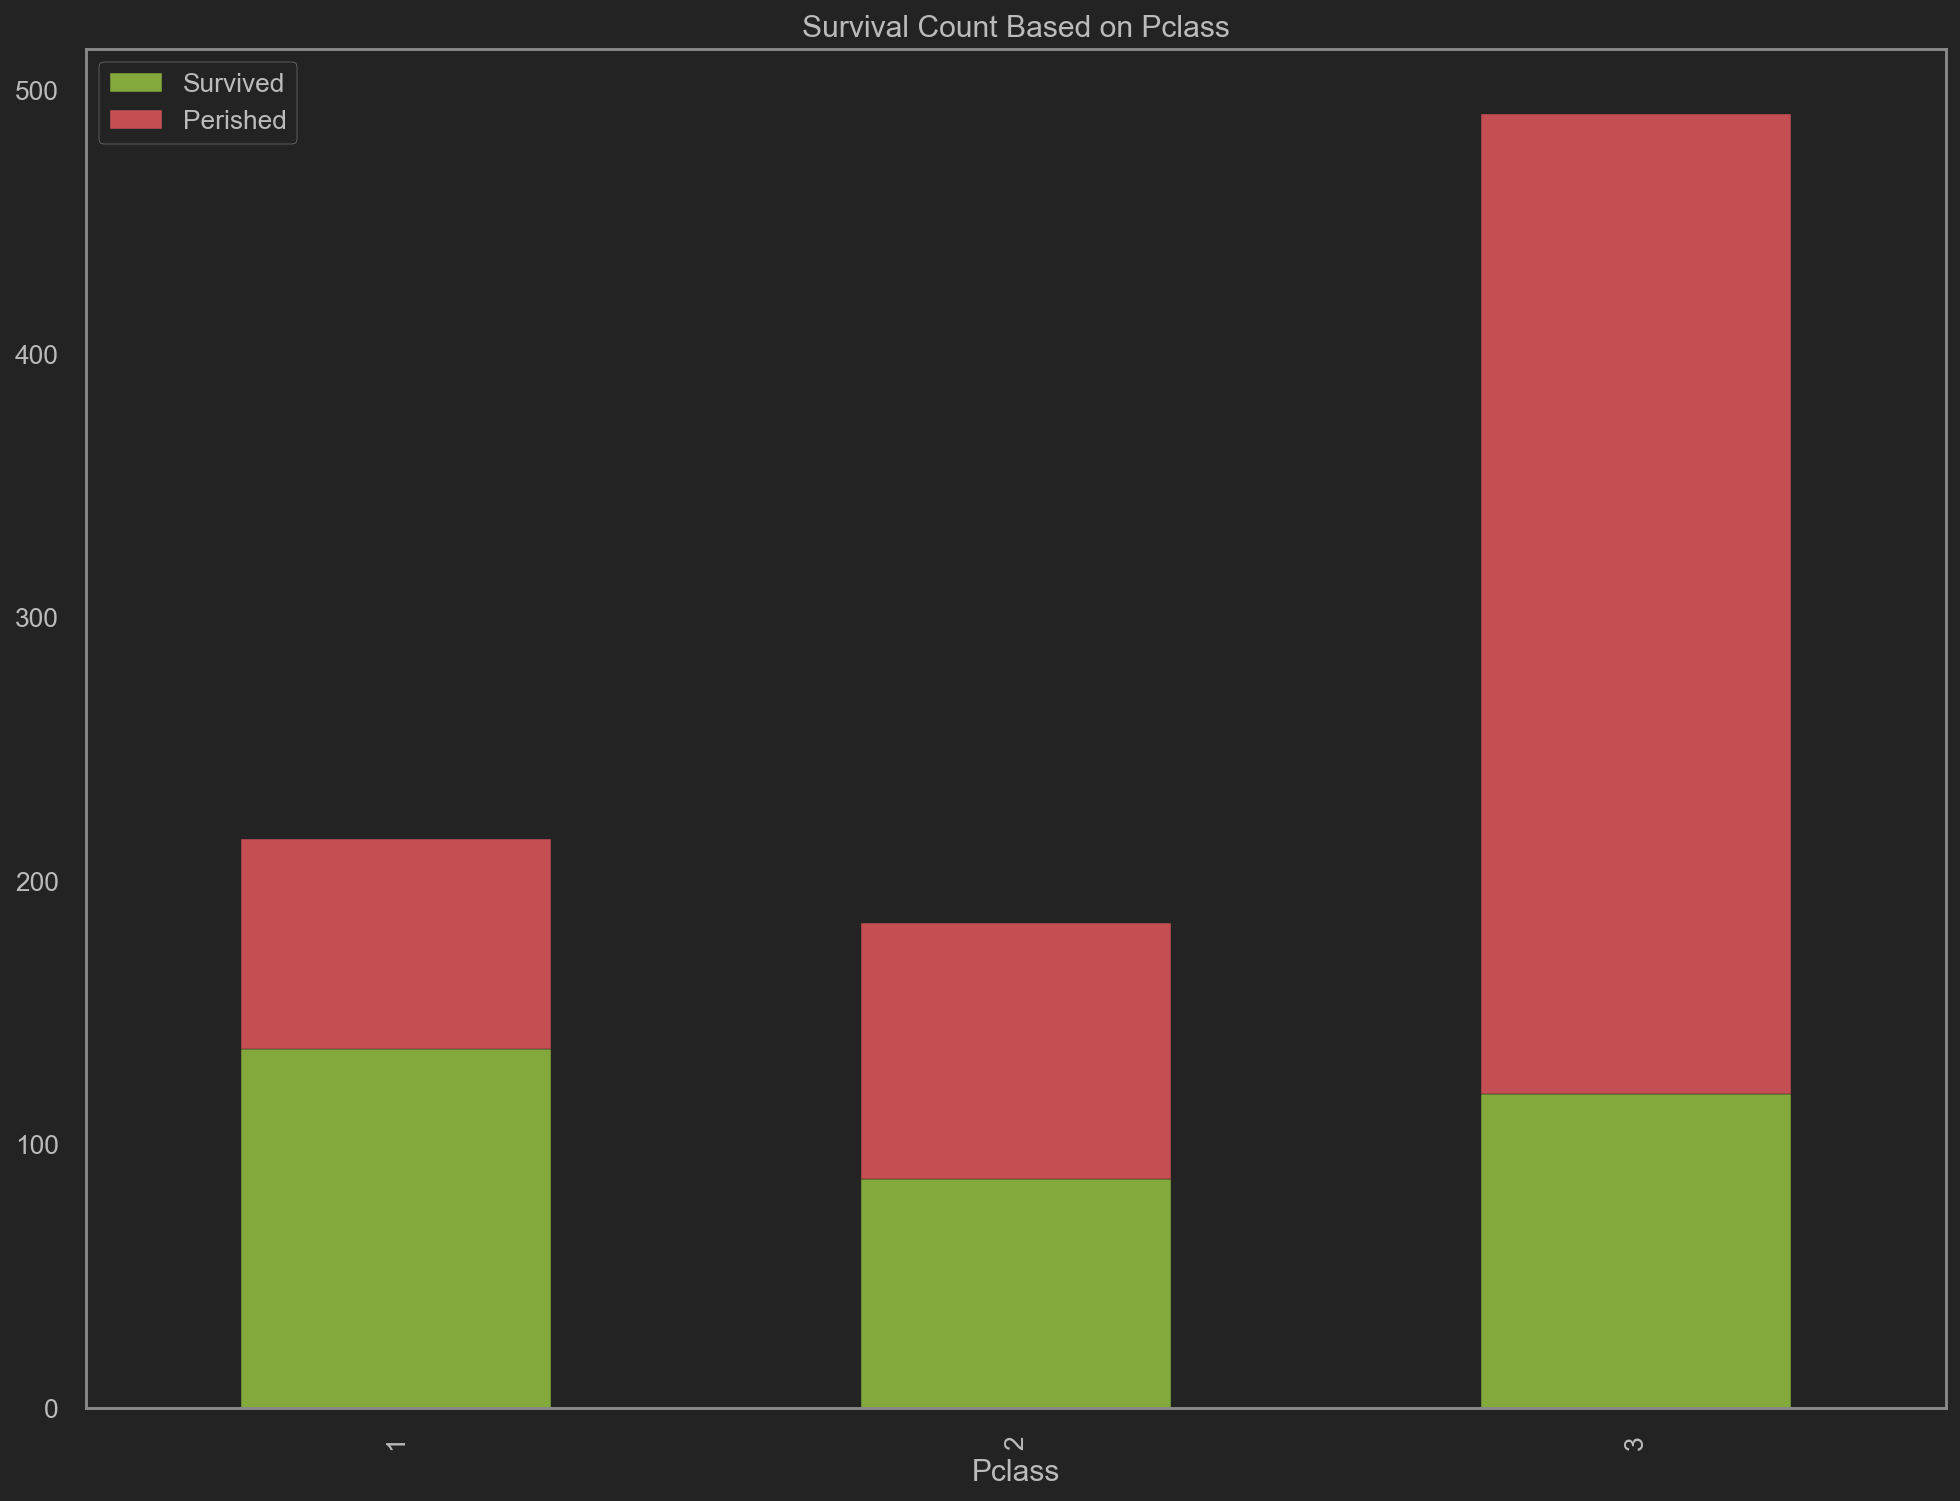

In [17]:
# 基于客舱等级的死亡计数
trainData.groupby('Pclass').agg('sum')[['Survived', 'Perished']]\
    .plot(kind='bar', stacked=True, color=['g', 'r'], title='Survival Count Based on Pclass', figsize=(16, 12))

+ 客舱等级为1的死亡率最低, 仅约37%
+ 客舱等级为3的死亡率最高, 约为75%
此时加入船票费用(`Fare`)验证客舱等级1是否为高价或低价舱位

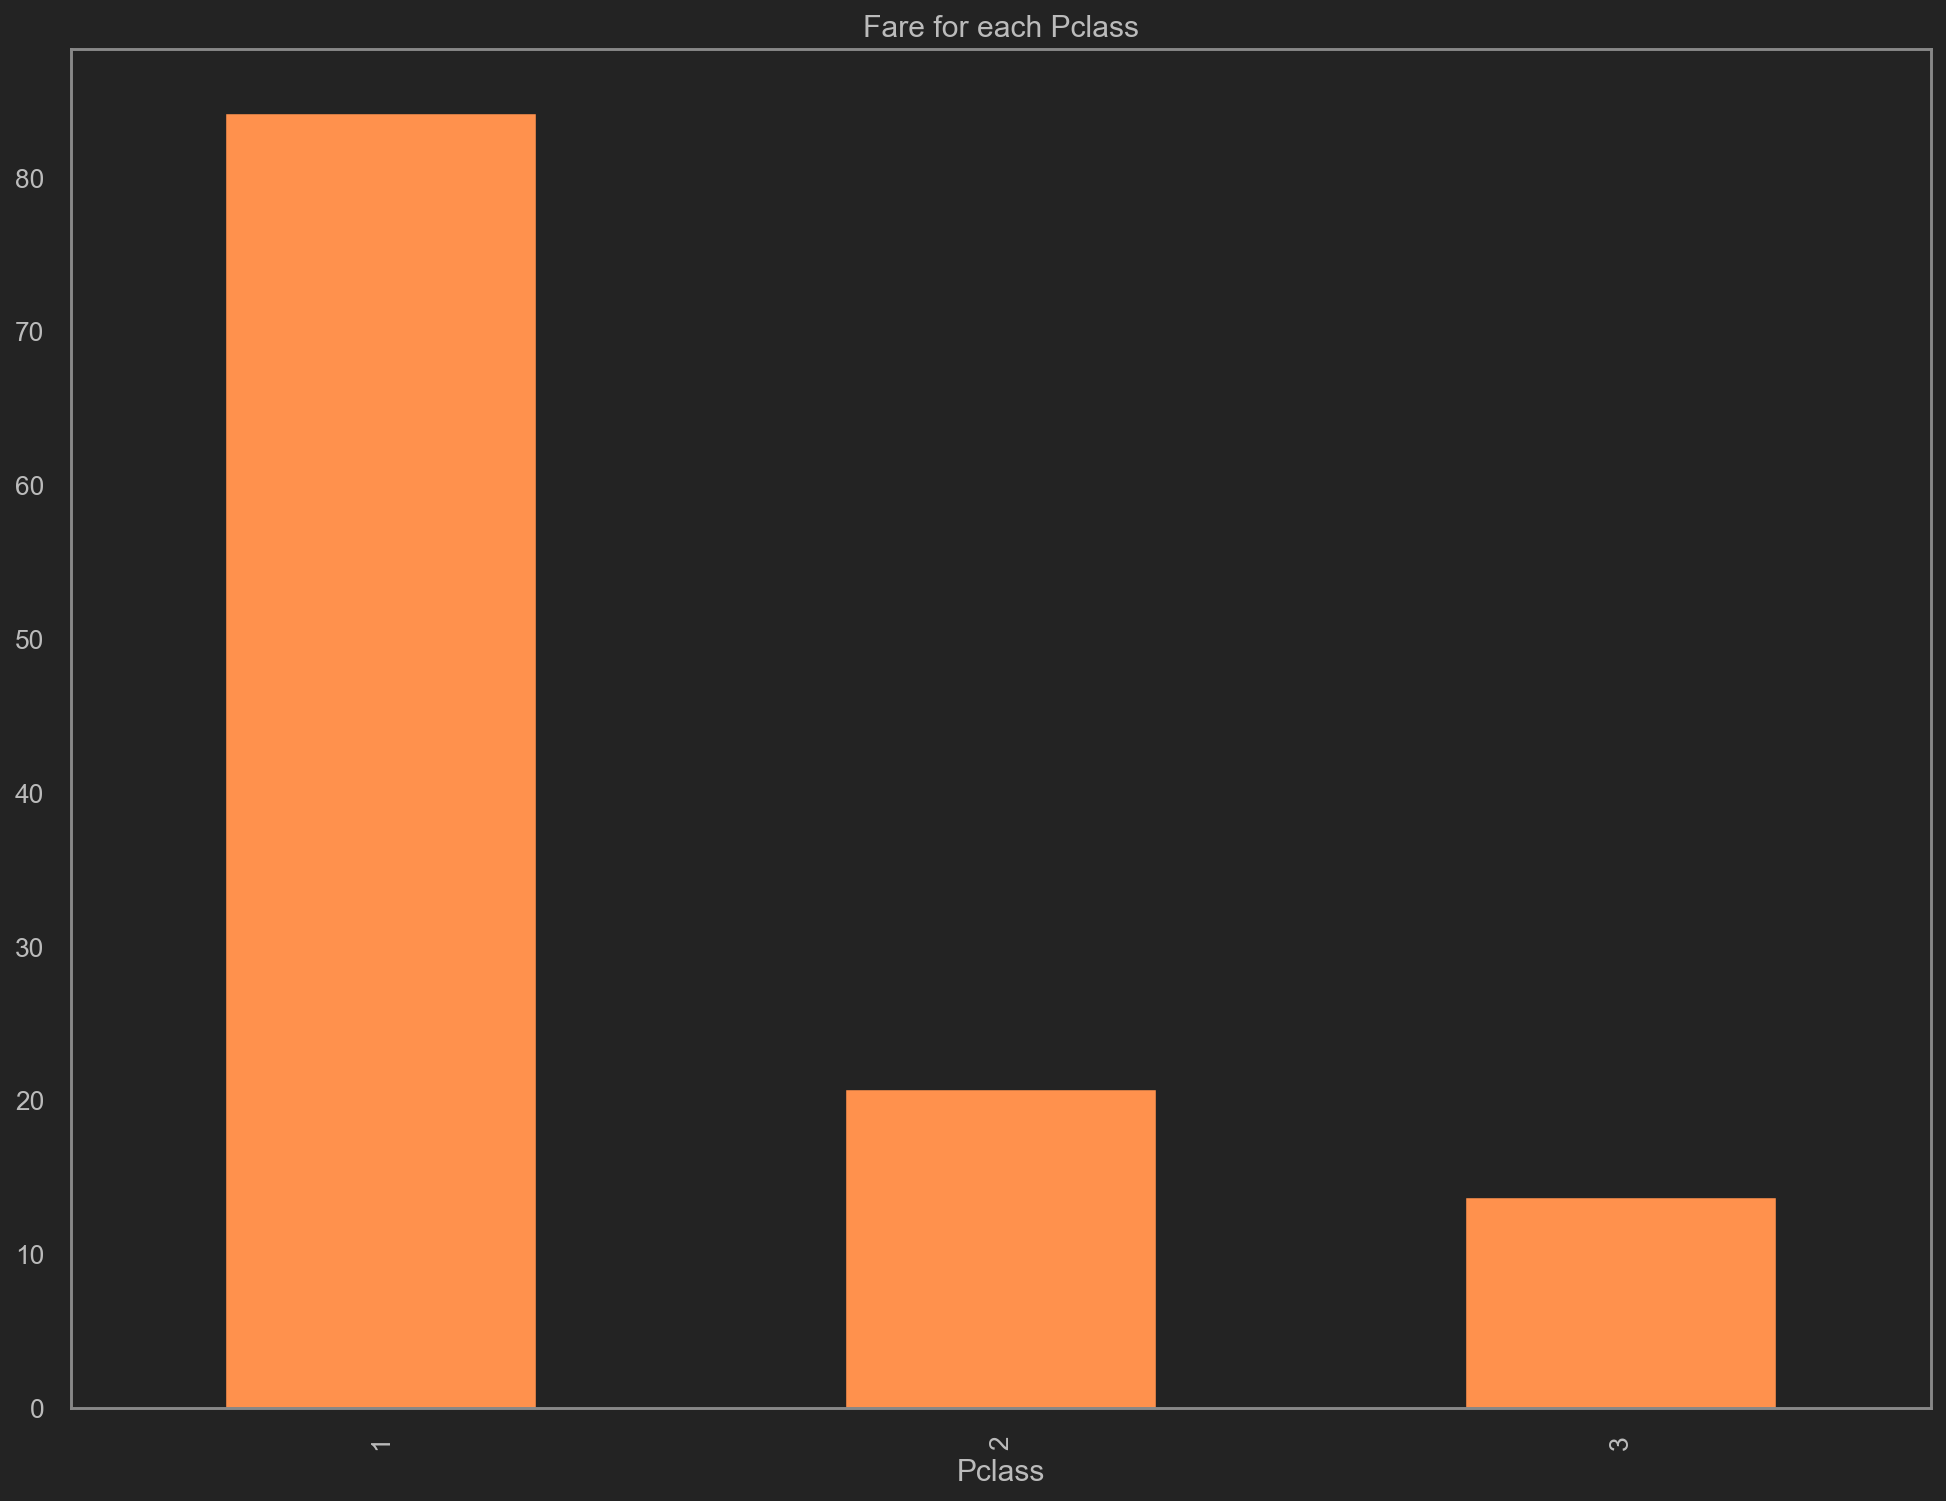

In [18]:
# 每个客舱等级对应的费用
trainData.groupby('Pclass').mean()['Fare'] \
    .plot(kind='bar', color='y', figsize=(16, 12), title='Fare for each Pclass')

验证上述猜想, 1号Pclass等级的客舱售价最高, 约80+美元, 而2, 3等级的客舱售价较低

## 结合船票费用与年龄将死亡率与分布可视化

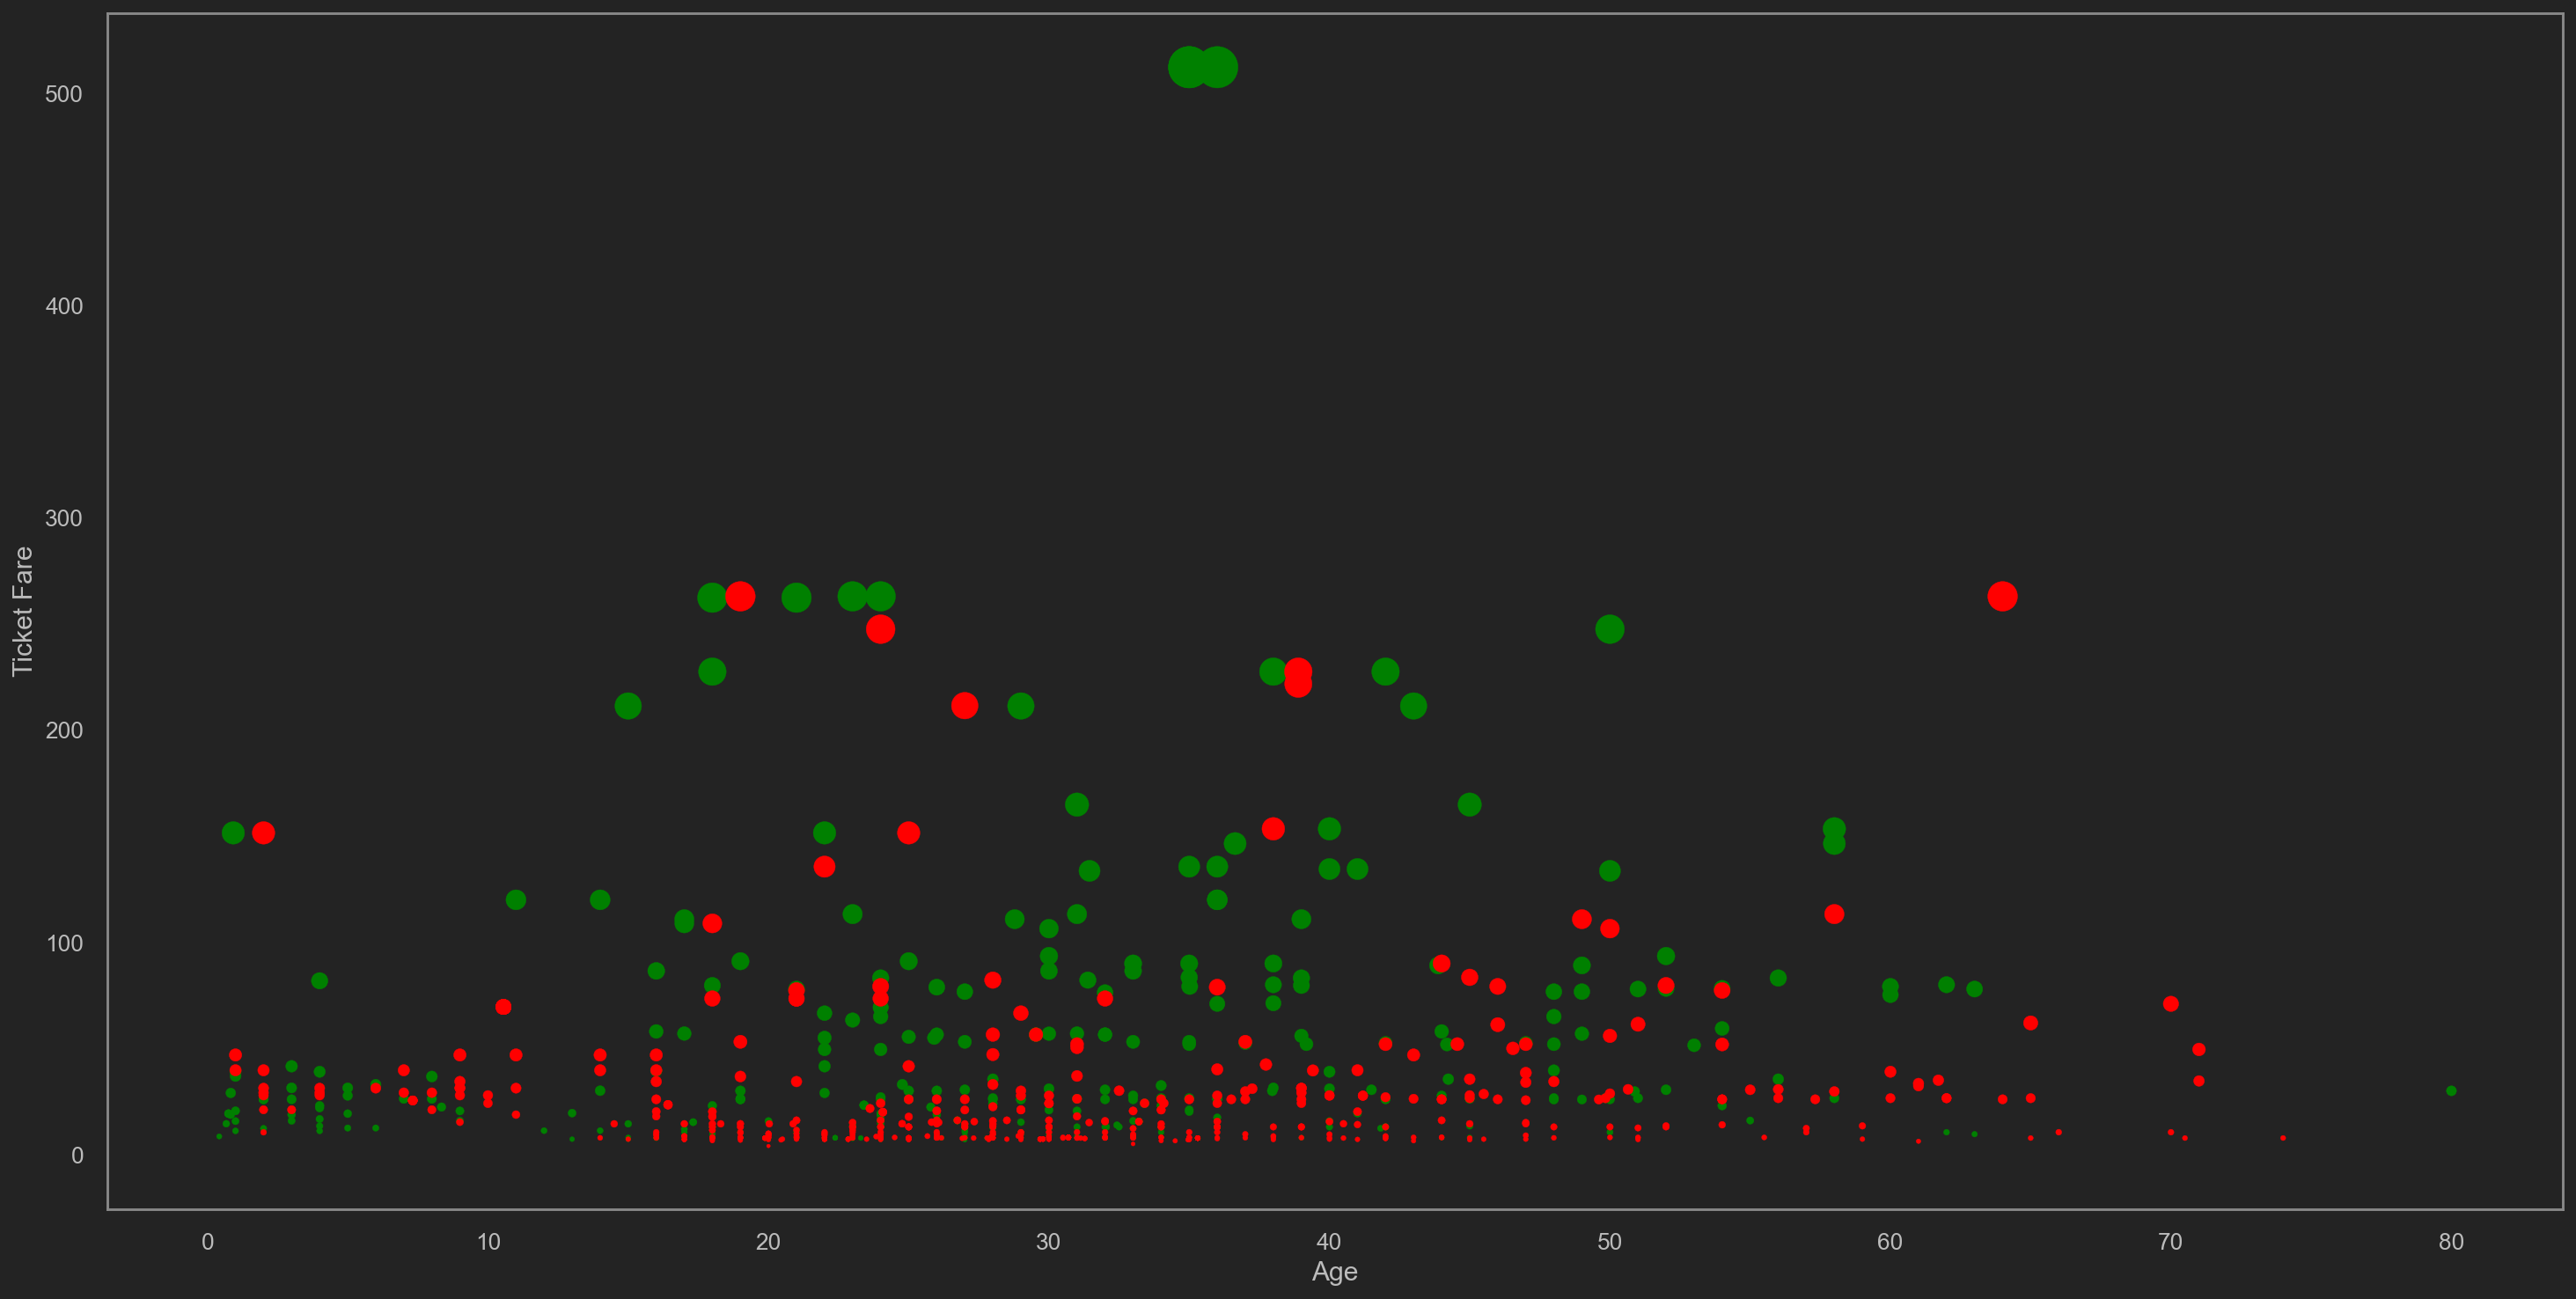

In [19]:
plt.figure(figsize=(24, 12))
plt.xlabel('Age')
plt.ylabel('Ticket Fare')
plt.scatter(trainData[trainData['Survived'] == 1]['Age'], trainData[trainData['Survived'] == 1]['Fare'], 
           c='green', s=trainData[trainData['Survived'] == 1]['Fare'])
plt.scatter(trainData[trainData['Survived'] == 0]['Age'], trainData[trainData['Survived'] == 0]['Fare'], 
           c='red', s=trainData[trainData['Survived'] == 0]['Fare'])

上述图的散点大小代表船票费用(`Fare`), x轴代表年龄(`Age`), y轴亦代表船票费用.

作以下说明
+ 称位于上图顶端的, 30<=Age(x axis)<=40, 绿色的散点为`聚类点1`
+ 称位于上图底端的, 20<=Age(x axis)<=40, 红色的散点为`聚类点2`
+ 称位于上图中心的, 10<=Age(x axis)<=40, 绿色的散点的为`聚类点3`
+ 称位于上图左下端, 0<=Age(x axis)<=10, 绿色的散点为`聚类点4`

聚类点1的出现, 表明票价最高的存活率亦最高.

聚类点2的出现, 表面票价最低的中年乘客存活率亦最低, 红点极其密集.

聚类点3的出现, 表面票价适中部分的中年乘客存活率相当可观.

聚类点4的出现, 是最有趣的, 他们属于拥有较低求生技能的一批乘客, 主要为婴幼儿与儿童, 但是存活率亦高.

可以判断婴幼儿与儿童相较于其他乘客, 获得更好的求生/救助资源. 该结论反射的观点也的确是明显受社会认可的(妇女儿童优先).

## 关注年龄

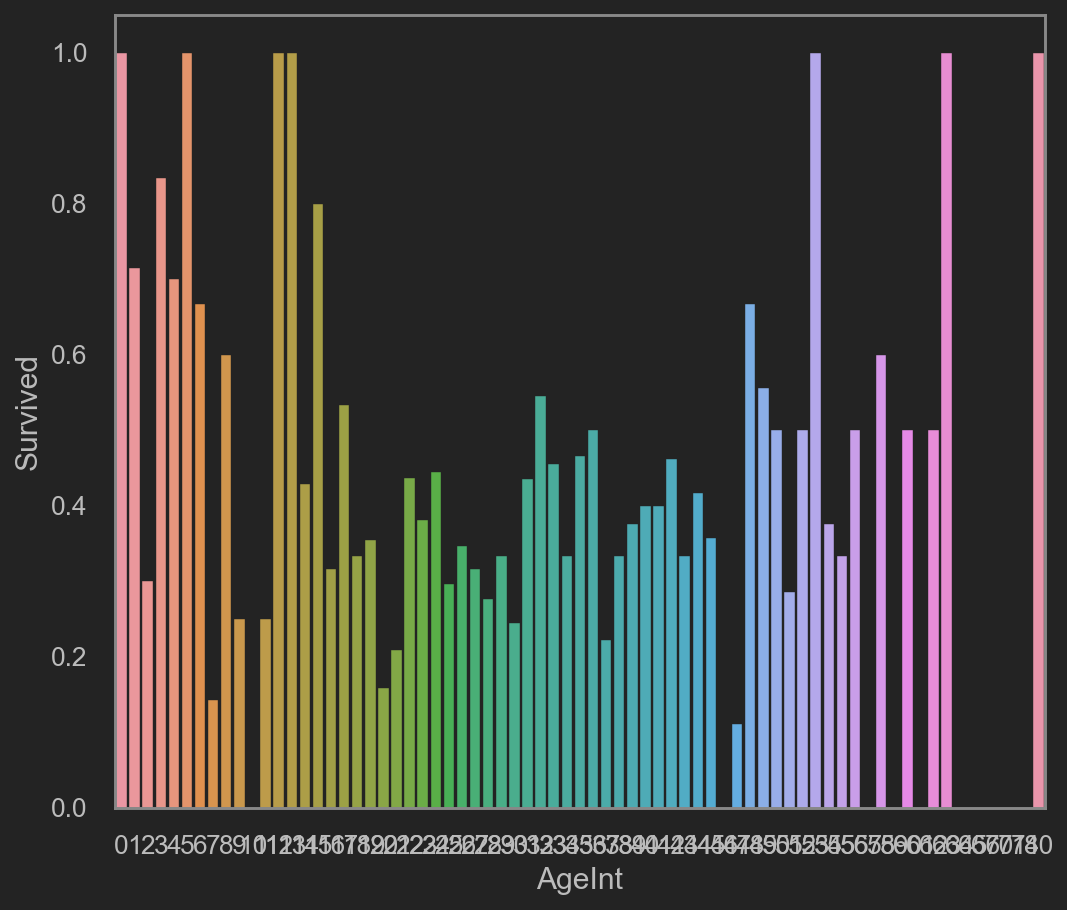

In [20]:
trainData["AgeInt"] = trainData["Age"].astype(int)
# 精确到每个年龄的成员成活率
avgAge = trainData[["AgeInt", "Survived"]].groupby(['AgeInt'], as_index=False).mean()
sns.barplot(x='AgeInt', y='Survived', data=avgAge)

In [21]:
separationPoint = [0, 6, 18, 40, 60, 100]
trainData['AgeBatch'] = pd.cut(trainData['AgeInt'], separationPoint)
batches = trainData.groupby('AgeBatch')['Survived'].mean()
# 按年龄段的存活率
batches

AgeBatch
(0, 6]       0.650000
(6, 18]      0.366972
(18, 40]     0.362522
(40, 60]     0.404255
(60, 100]    0.217391
Name: Survived, dtype: float64

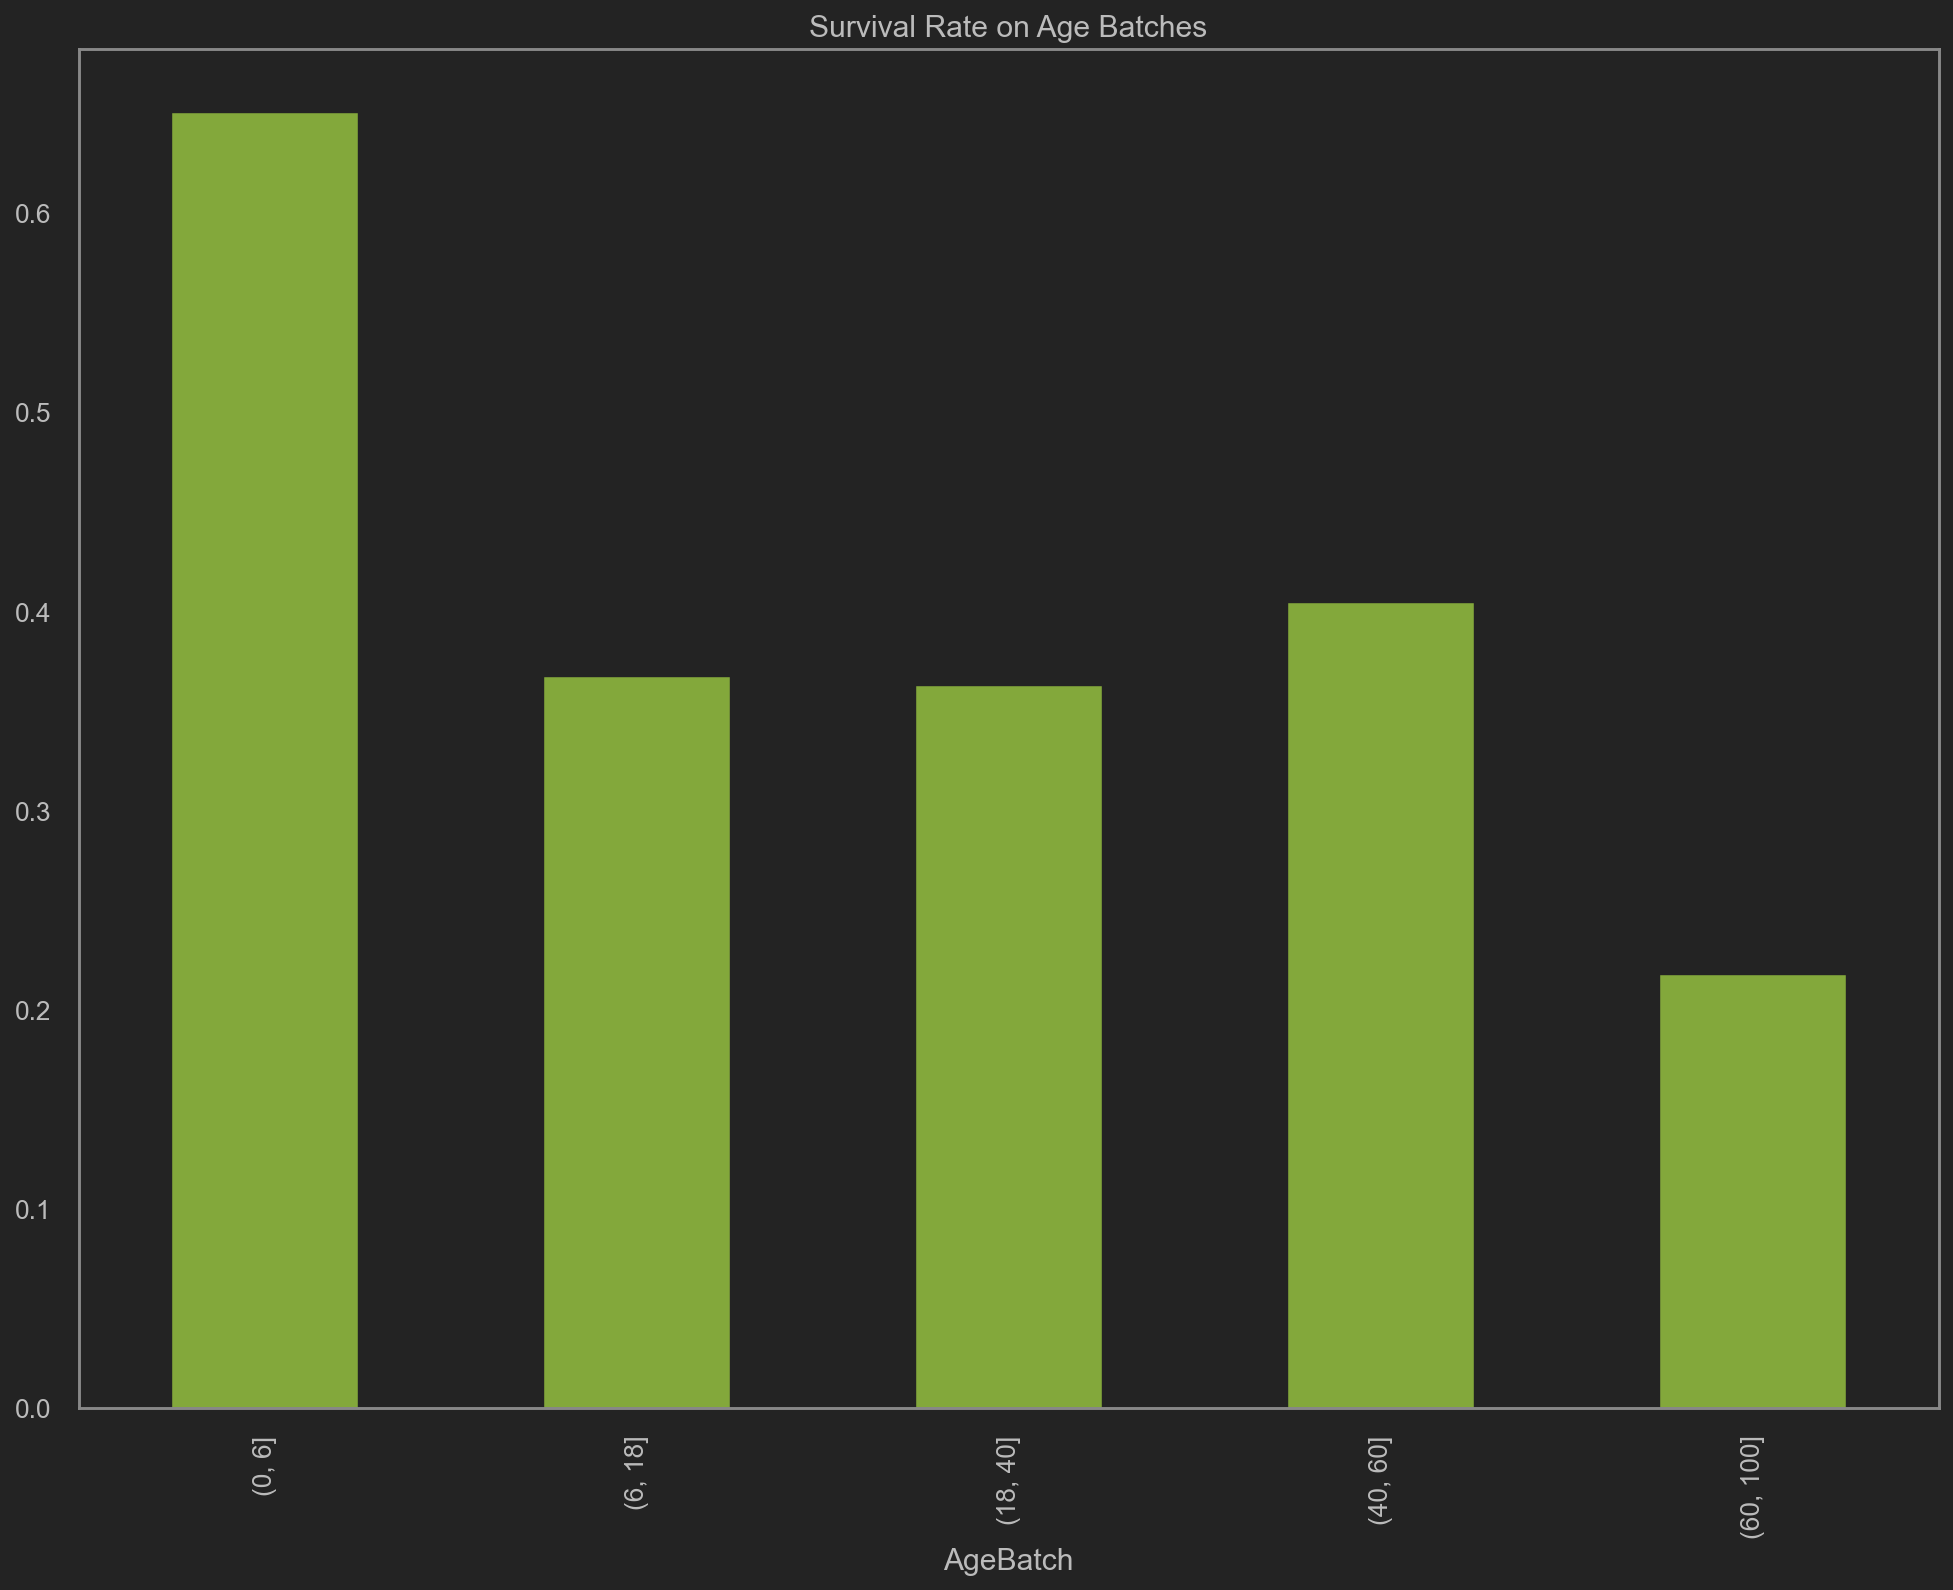

In [22]:
batches.plot(kind='bar', color='g', figsize=(16, 12), title='Survival Rate on Age Batches')

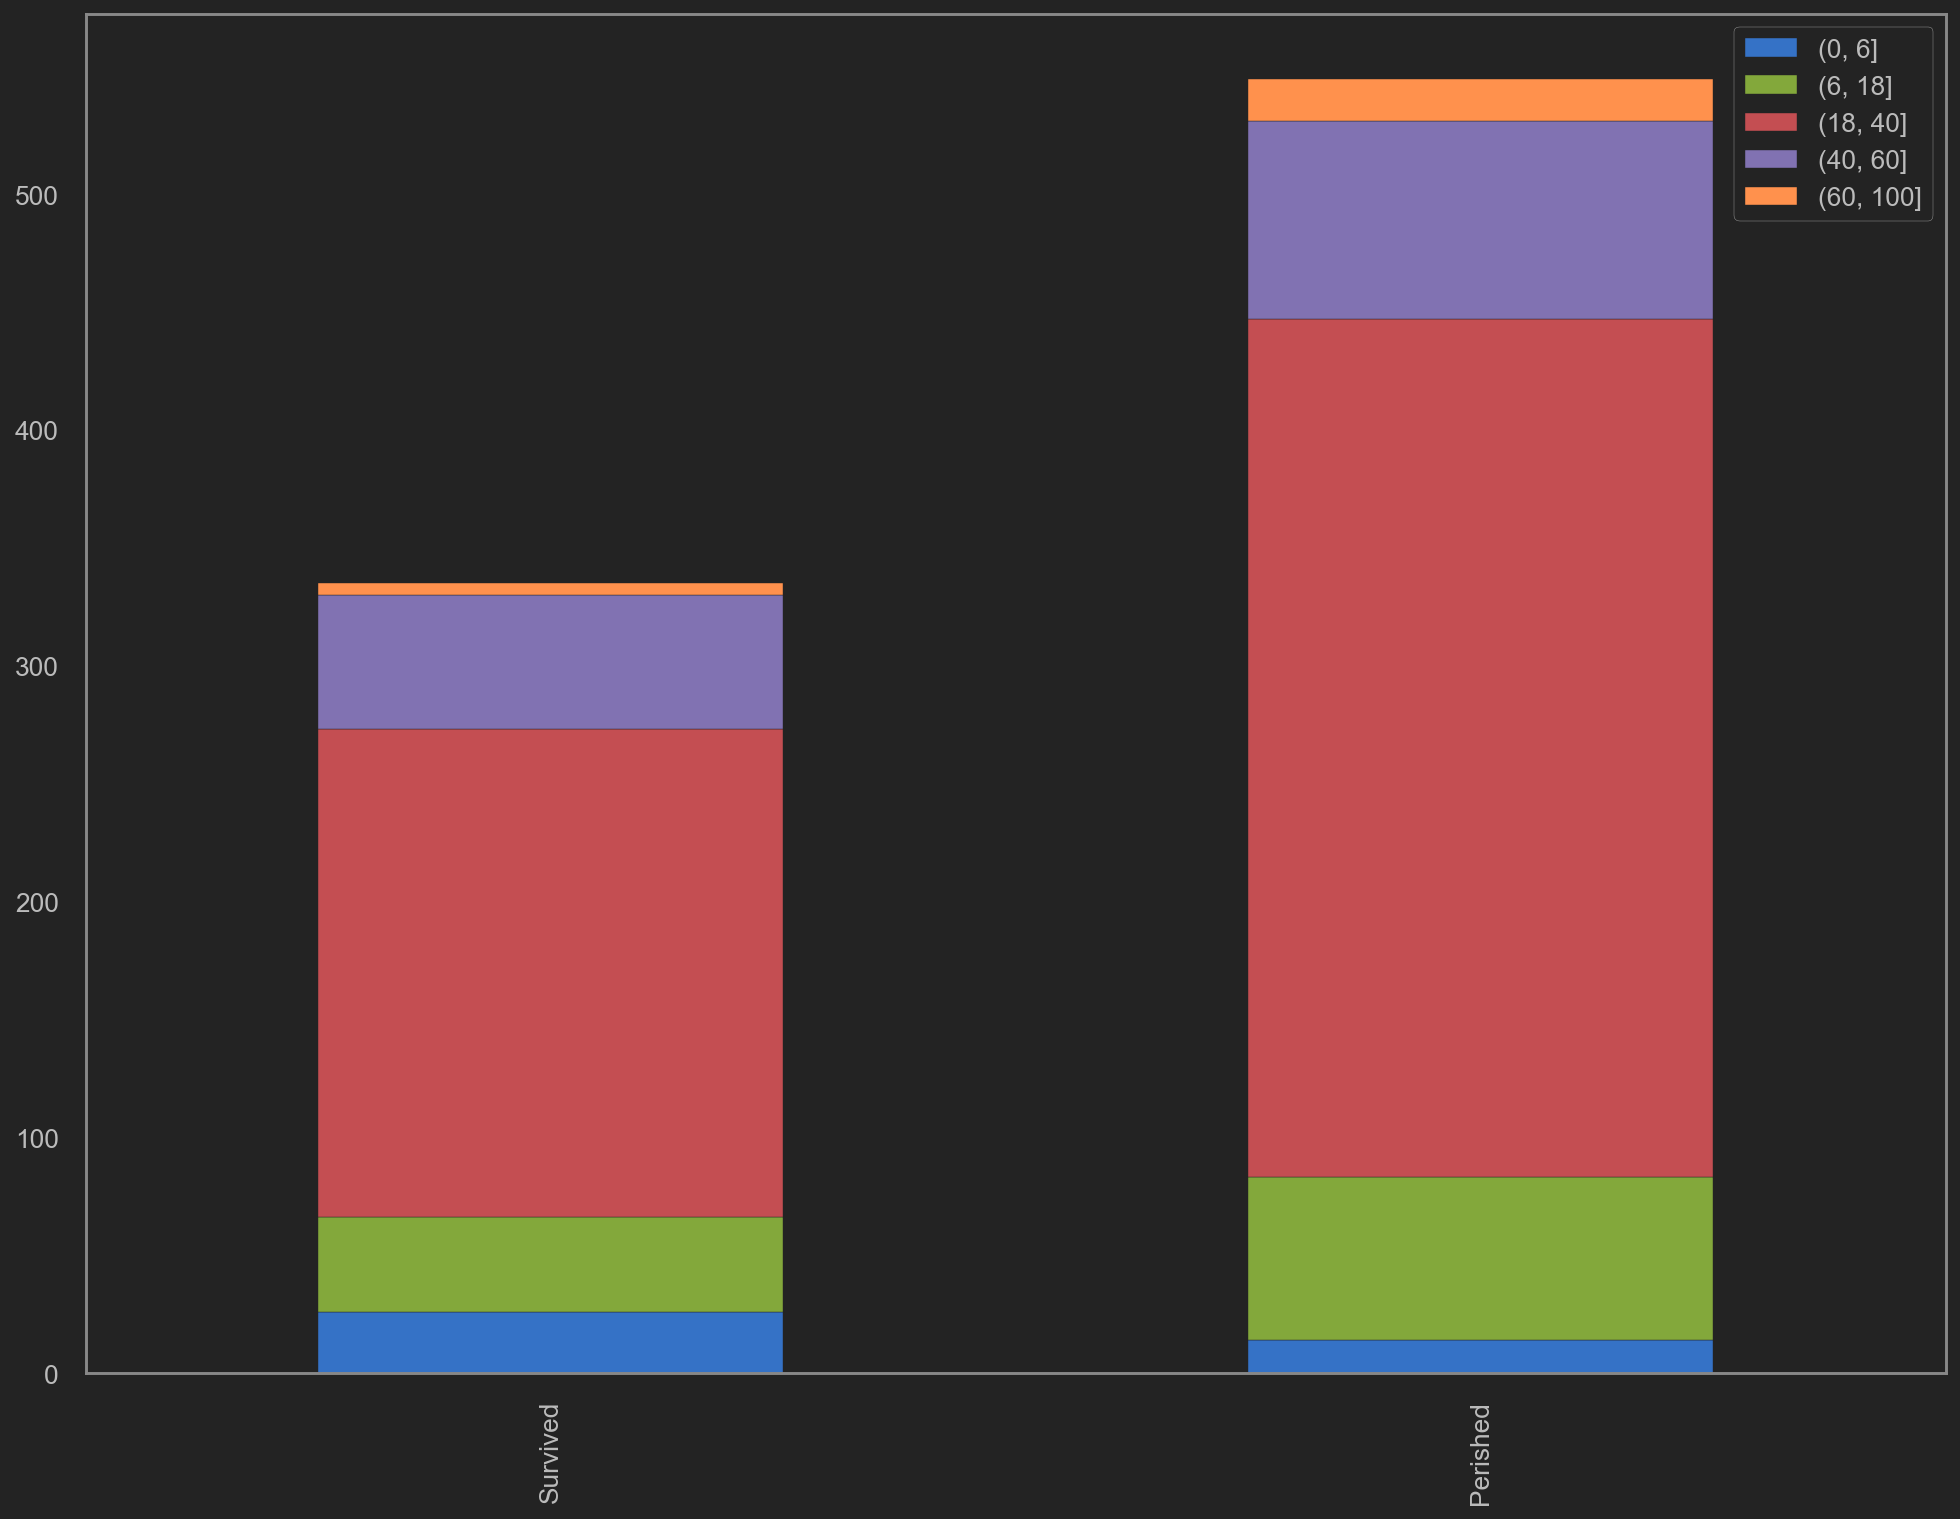

In [23]:
survivedtmp = trainData[trainData['Survived']==1]['AgeBatch'].value_counts()
perishedtmp = trainData[trainData['Survived']==0]['AgeBatch'].value_counts()
dftmp = pd.DataFrame([survivedtmp, perishedtmp])
dftmp.index = ['Survived','Perished']
dftmp.plot(kind='bar', stacked=True, figsize=(16, 12))

> **上一柱图颜色仅为区分年龄段**

上述年龄-存活率分布图更是验证了上面的说法, `（0, 6]`的年龄段可以获得65%的存活率.

婴幼儿/儿童对应的某些年龄段, 获得了甚至接近100%的存活率.

老人对应的年龄段, 考虑到他们的身体条件, 该存活率表现也足以表明社会救助的确有偏向性.

## 考虑有无子女上船`SibSp`

Text(0, 0.5, 'Survival Rate')

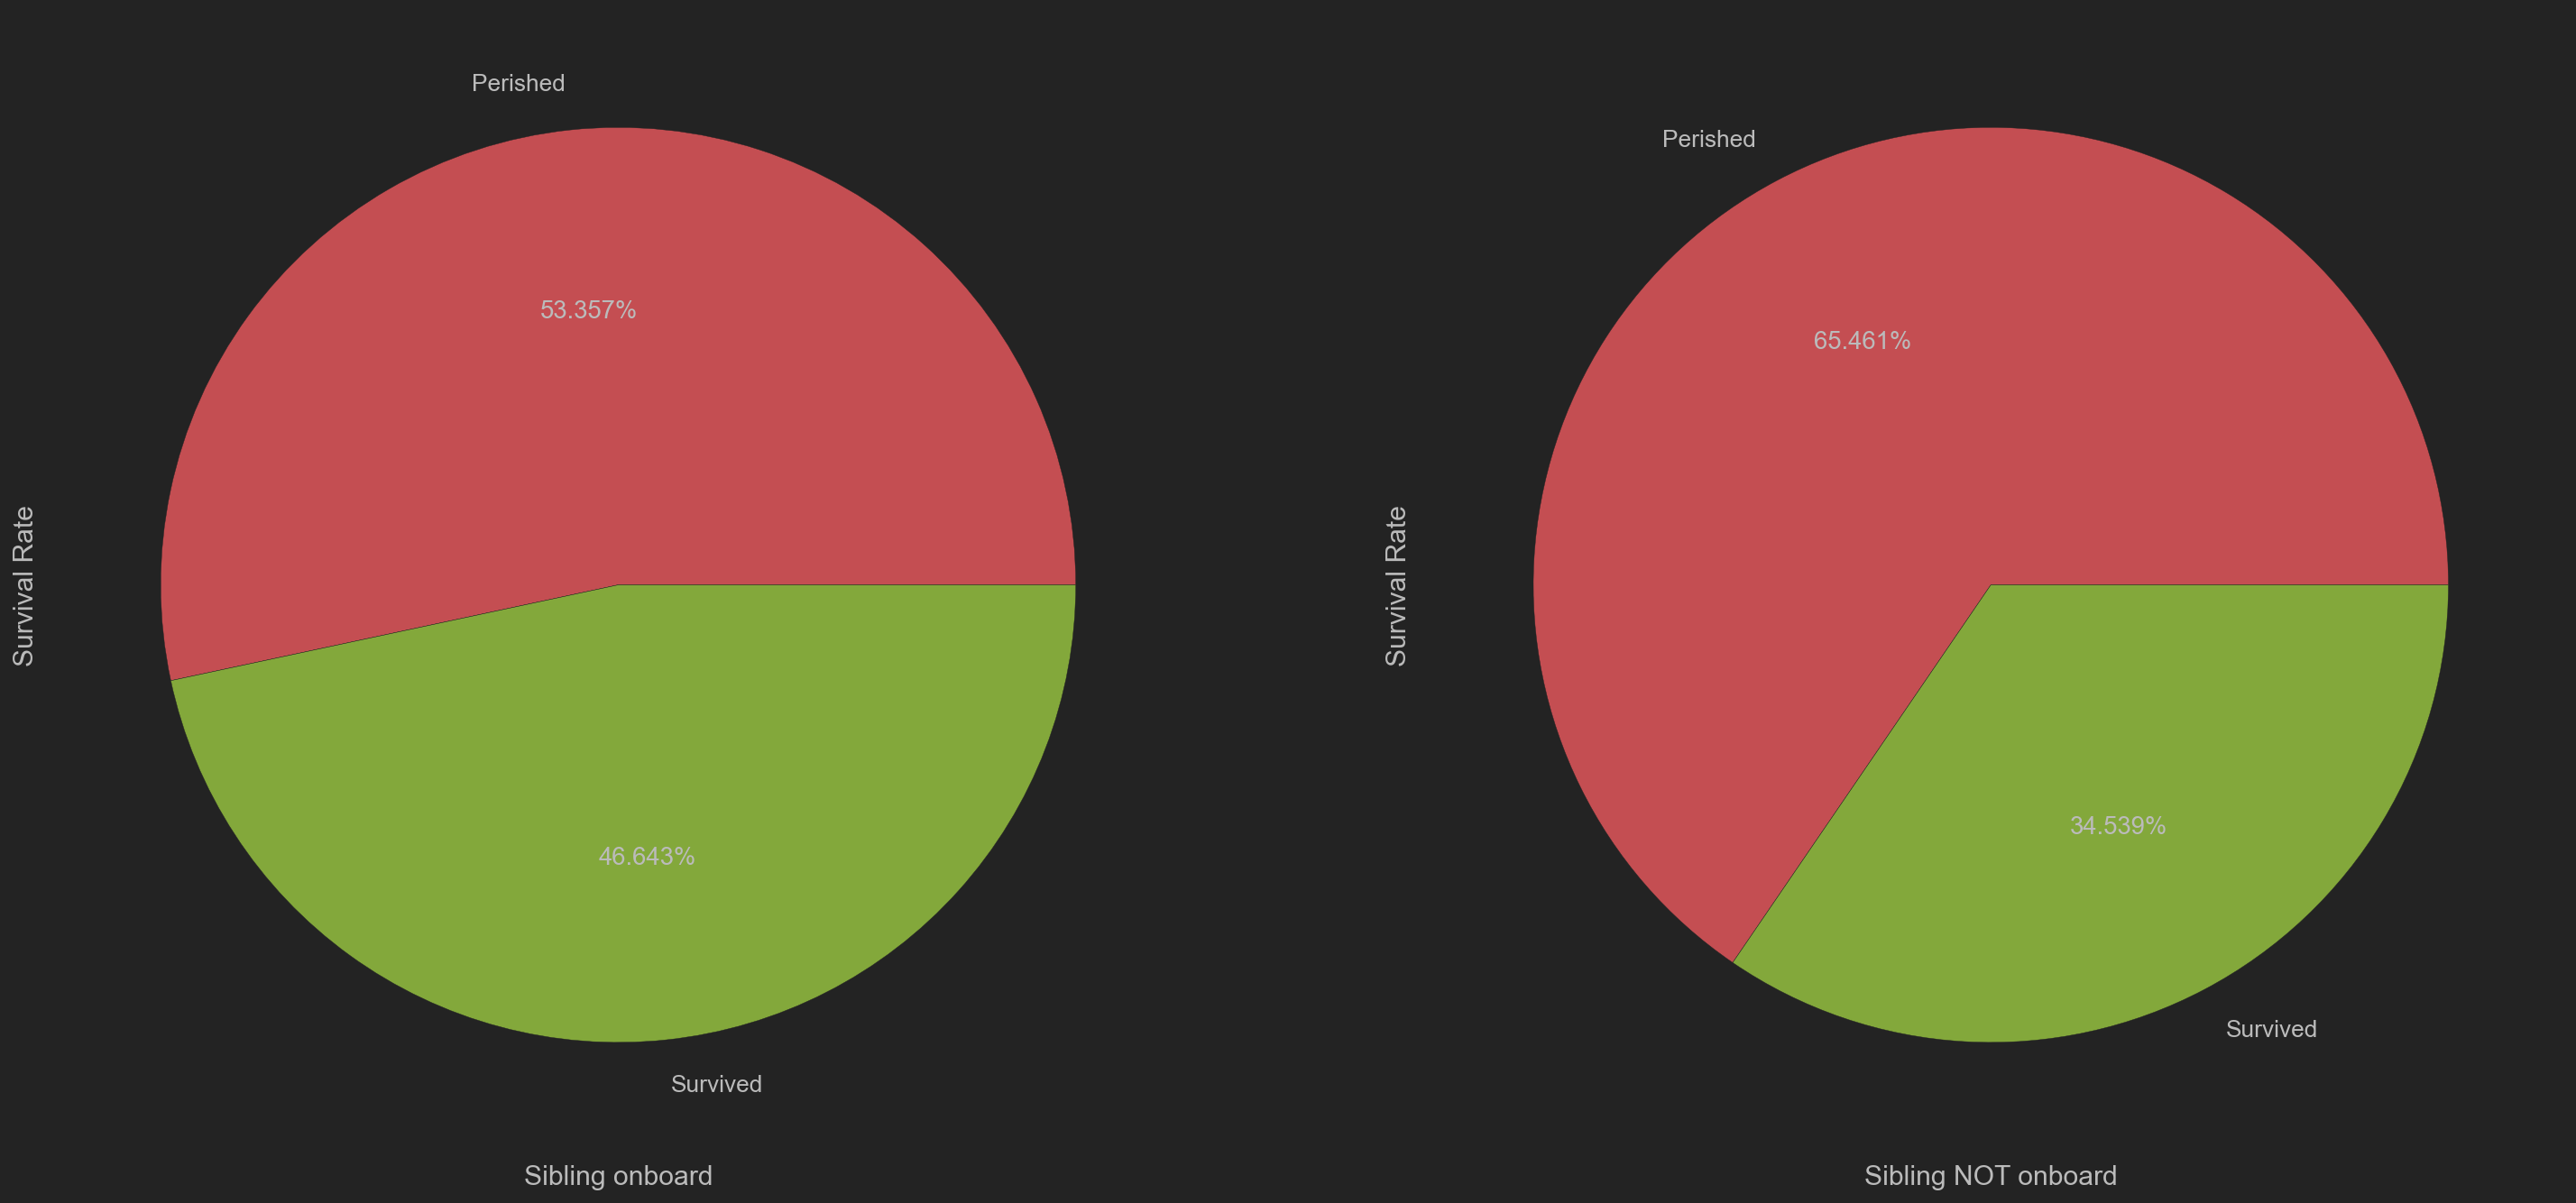

In [24]:
# 根据有无子女上船, 划分数据
# OB-> On board, NOB-> NOT on board
siblOB = trainData[trainData['SibSp'] != 0]
siblNOB = trainData[trainData['SibSp'] == 0]
plt.figure(figsize=(24, 12))
plt.subplot(121)
siblOB['Survived'].value_counts().\
        plot(kind='pie', labels=['Perished', 'Survived'], autopct='%.3f%%', colors=['r', 'g'])
plt.xlabel('Sibling onboard')
plt.ylabel('Survival Rate')
plt.subplot(122)
siblNOB['Survived'].value_counts().\
        plot(kind='pie', labels=['Perished', 'Survived'], autopct='%.3f%%', colors=['r', 'g'])
plt.xlabel('Sibling NOT onboard')
plt.ylabel('Survival Rate')

## 考虑有无父母上船`Parch`

Text(0, 0.5, 'Survival Rate')

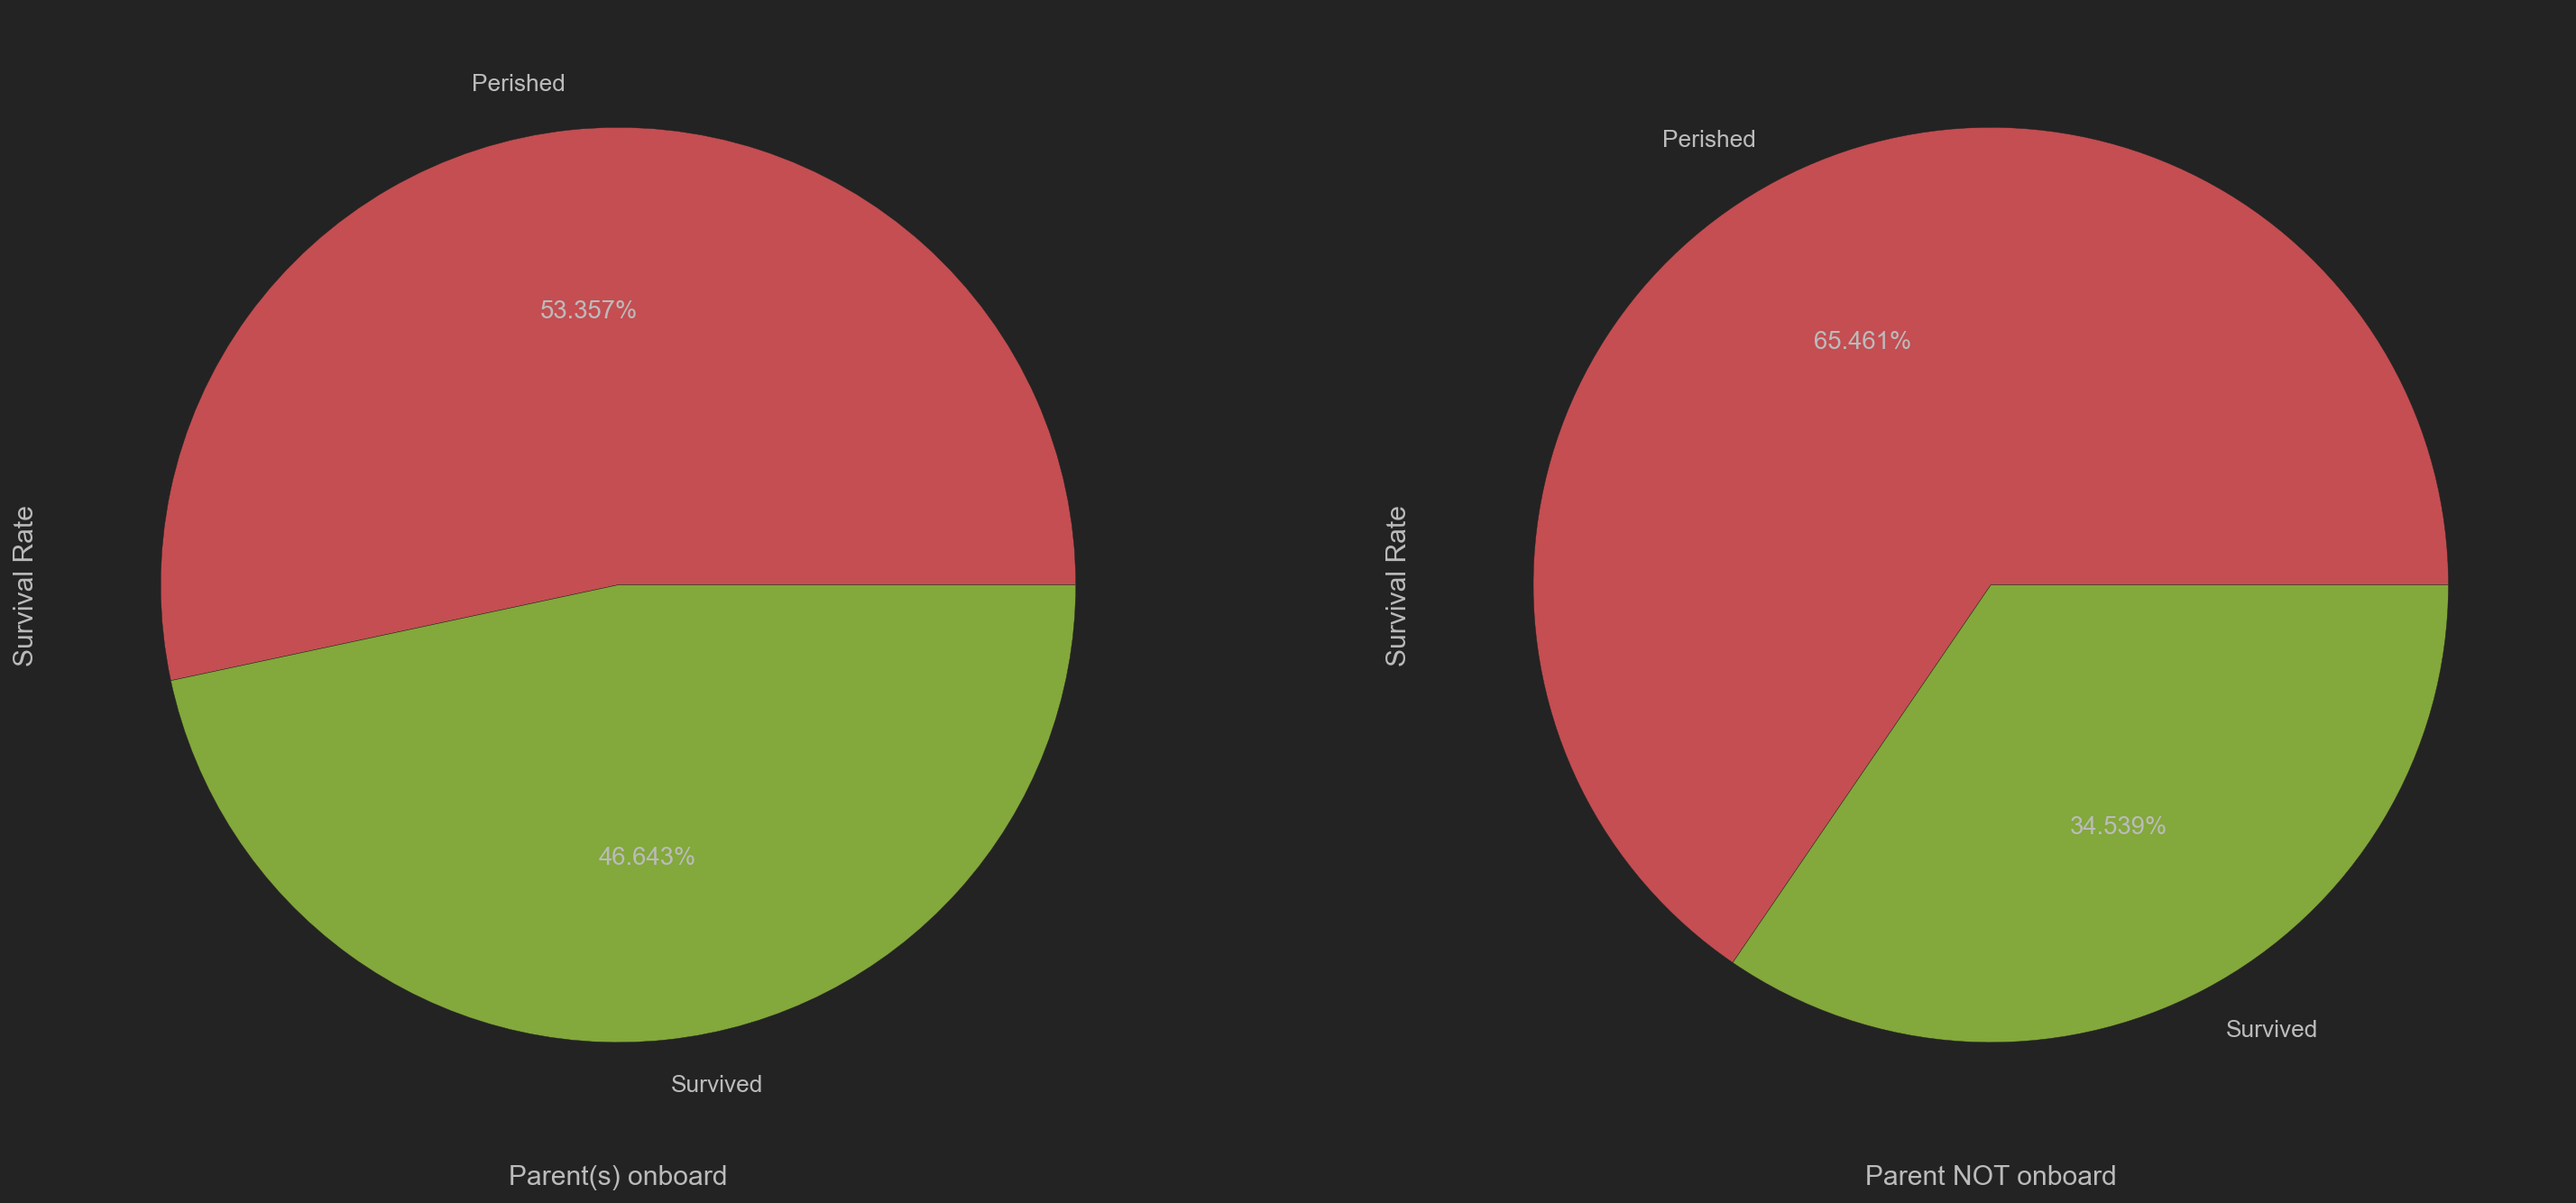

In [25]:
# 根据有无父母上船, 划分数据
# OB-> On board, NOB-> NOT on board
parentOB = trainData[trainData['Parch'] != 0]
parentNOB = trainData[trainData['Parch'] == 0]
plt.figure(figsize=(24, 12))
# plt.title('Survival Rate Based on Parents Onboard/Not Onboard')
plt.subplot(121)
siblOB['Survived'].value_counts()\
        .plot(kind='pie', labels=['Perished', 'Survived'], autopct='%.3f%%', colors=['r', 'g'])
plt.xlabel('Parent(s) onboard')
plt.ylabel('Survival Rate')
plt.subplot(122)
siblNOB['Survived'].value_counts()\
        .plot(kind='pie', labels=['Perished', 'Survived'], autopct='%.3f%%', colors=['r', 'g'])
plt.xlabel('Parent NOT onboard')
plt.ylabel('Survival Rate')

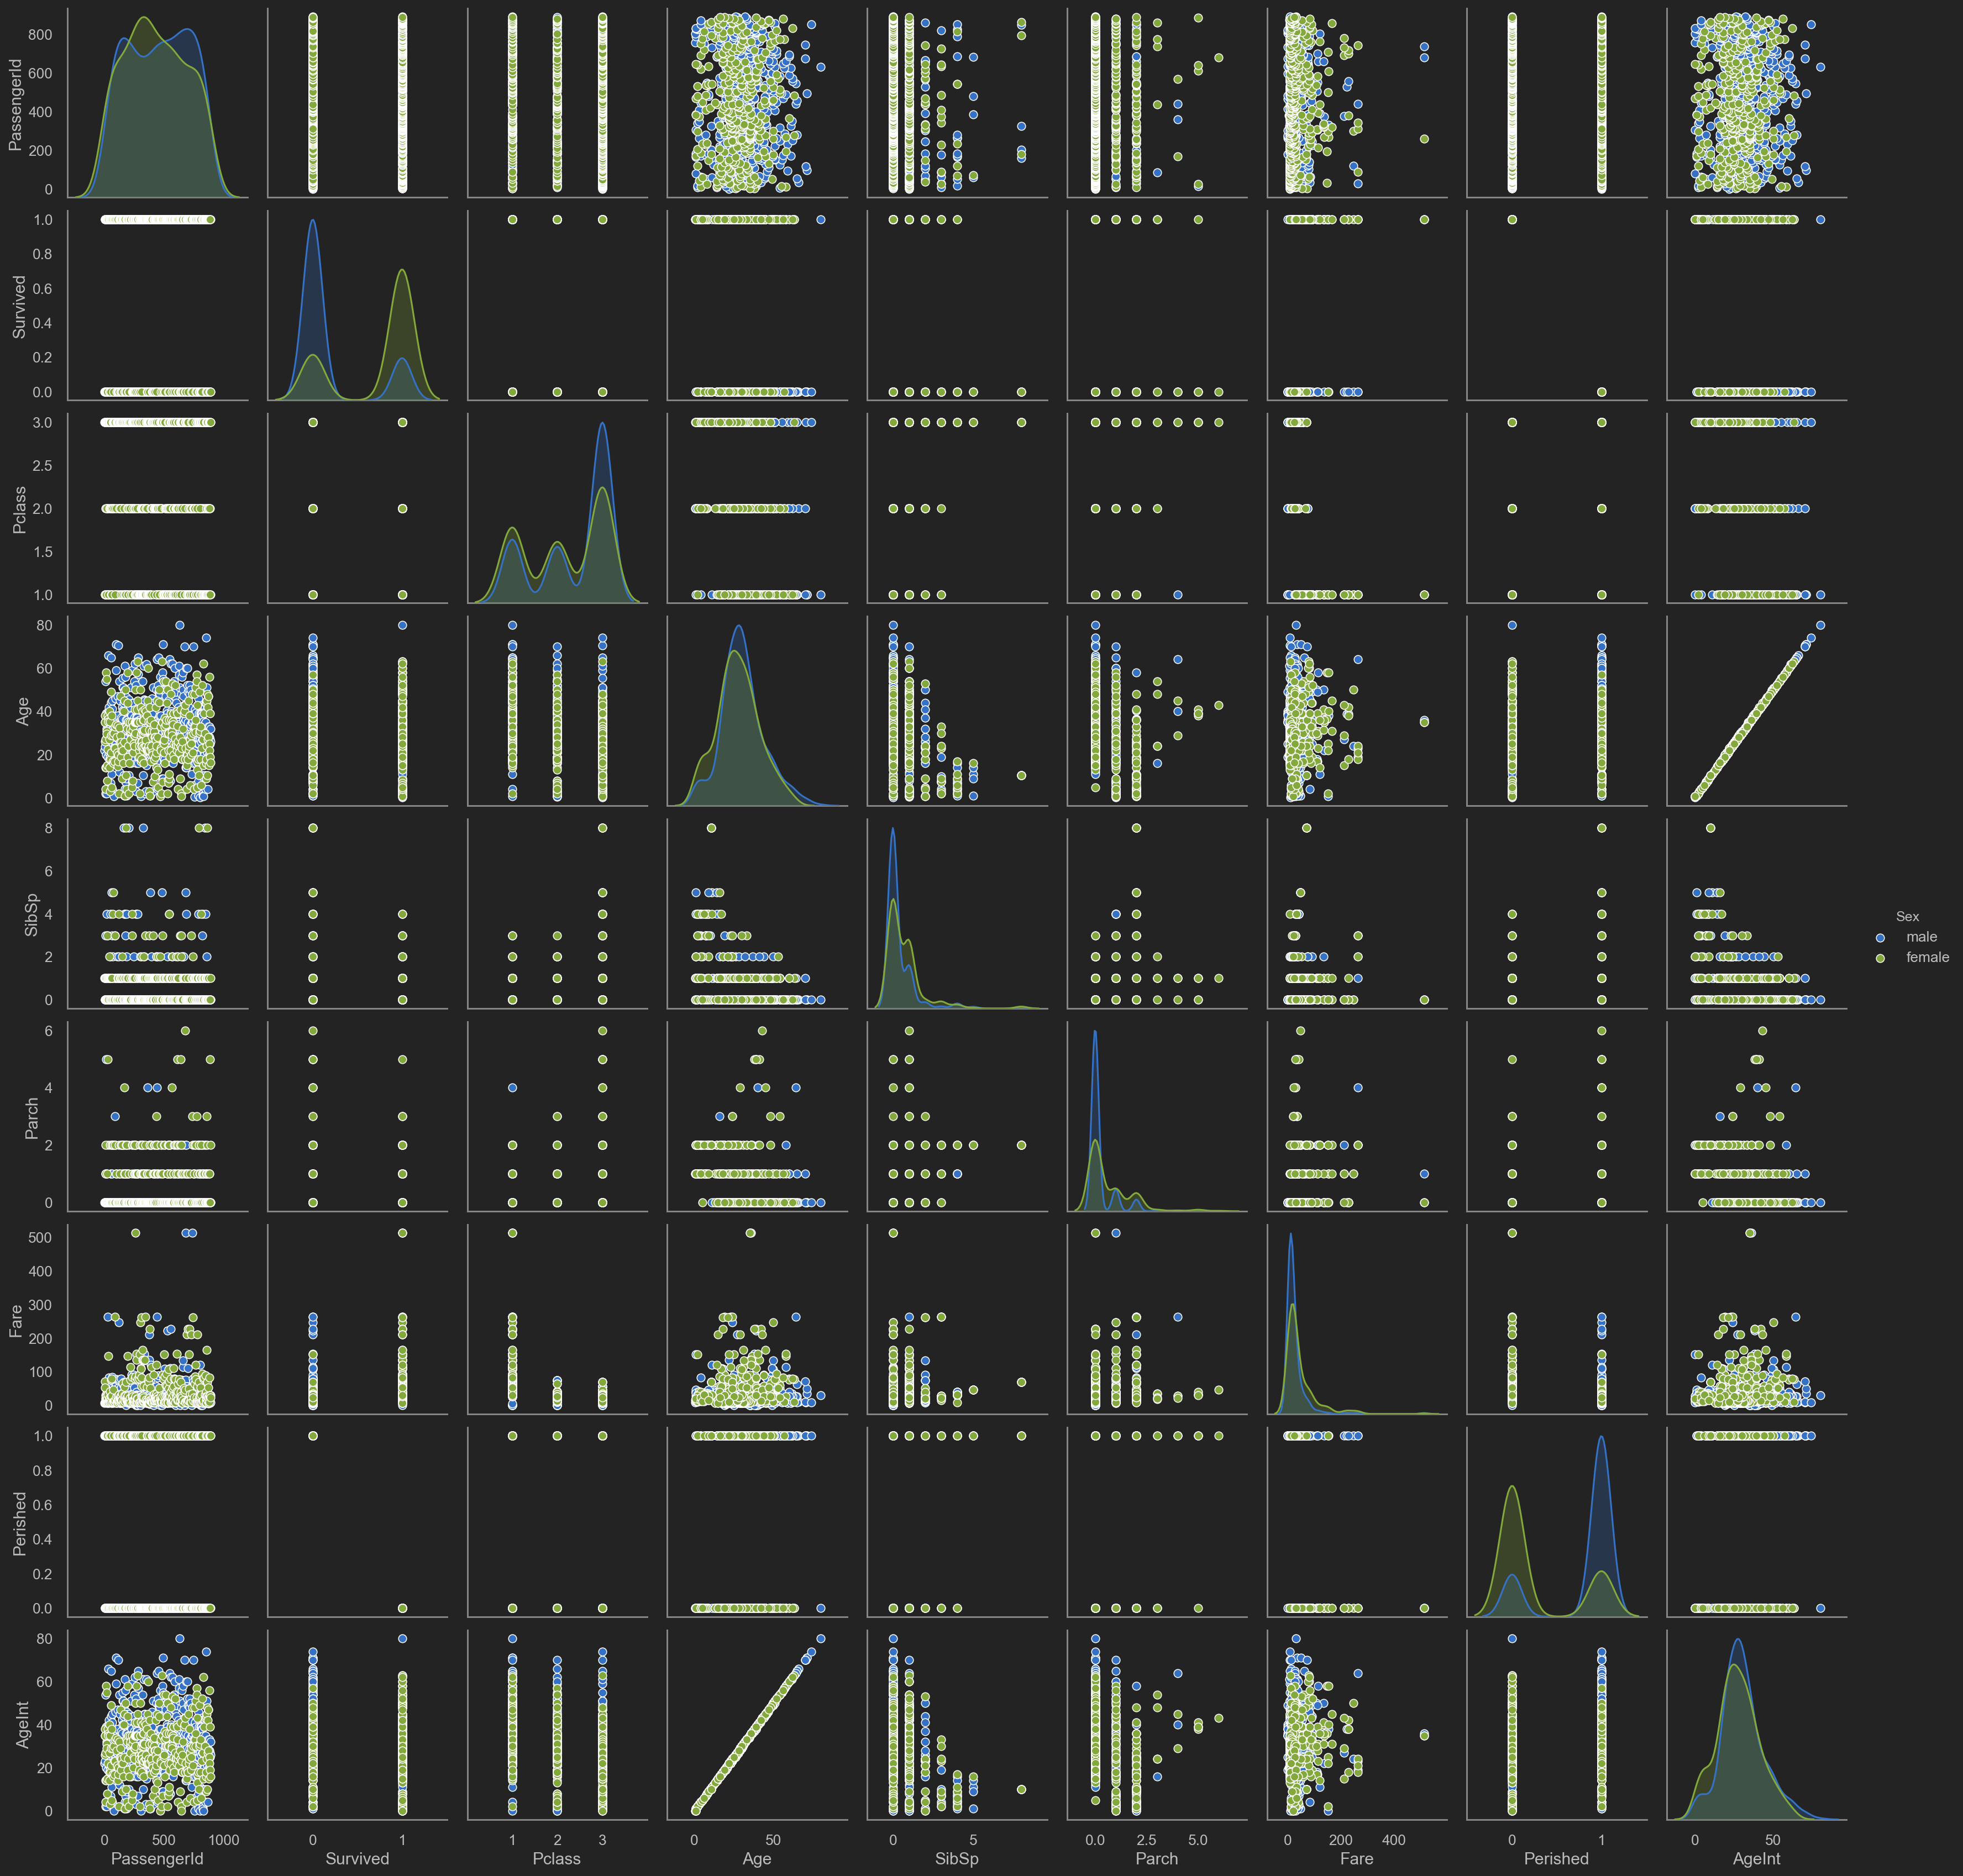

In [26]:
sns.pairplot(trainData, hue='Sex')

明显可以看出: 有父母或子女上船的乘客, 存活率都较`比较组(父母或儿女未在船上)`高.

## 热力图

将`trainData`中数据复制一份至`heatMapData`, 并去除相关系数较低的和上面新增的无用的字段, 如`PassengerId`类, 并将需要列化的数据进行`ONE-HOT`或`BINARY`编码.

对某些数据做Scaling, 以增大其敏感度.

并且将子女数量`SibSp`, 与父母数量`Parch`归为一个字段`F(amily)M(embers)Count`->"家庭成员数"

> 家庭成员数 = 子女数+父母数+自己

> `FamilyMembersCount = SibSp + Parch + 1 `

In [27]:
heatMapData = trainData.copy(deep=True)
heatMapData['FMCount'] = heatMapData['Parch'] + heatMapData['SibSp'] + 1
heatMapData.drop(['Name','Ticket','Cabin','PassengerId','AgeBatch', 'AgeInt', 'Perished', 'SibSp', 'Parch'], 1, inplace =True)
heatMapData.Sex.replace(('male','female'), (0,1), inplace = True)
heatMapData.Embarked.replace(('S','C','Q'), (1,2,3), inplace = True)
# 有两行上船地点数据丢失, 用1Replace, 影响不大
heatMapData.Embarked.fillna(1, inplace=True)
heatMapData.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,FMCount
0,0,3,0,22.0,7.2500,1.0,2
1,1,1,1,38.0,71.2833,2.0,2
2,1,3,1,26.0,7.9250,1.0,1
3,1,1,1,35.0,53.1000,1.0,2
4,0,3,0,35.0,8.0500,1.0,1


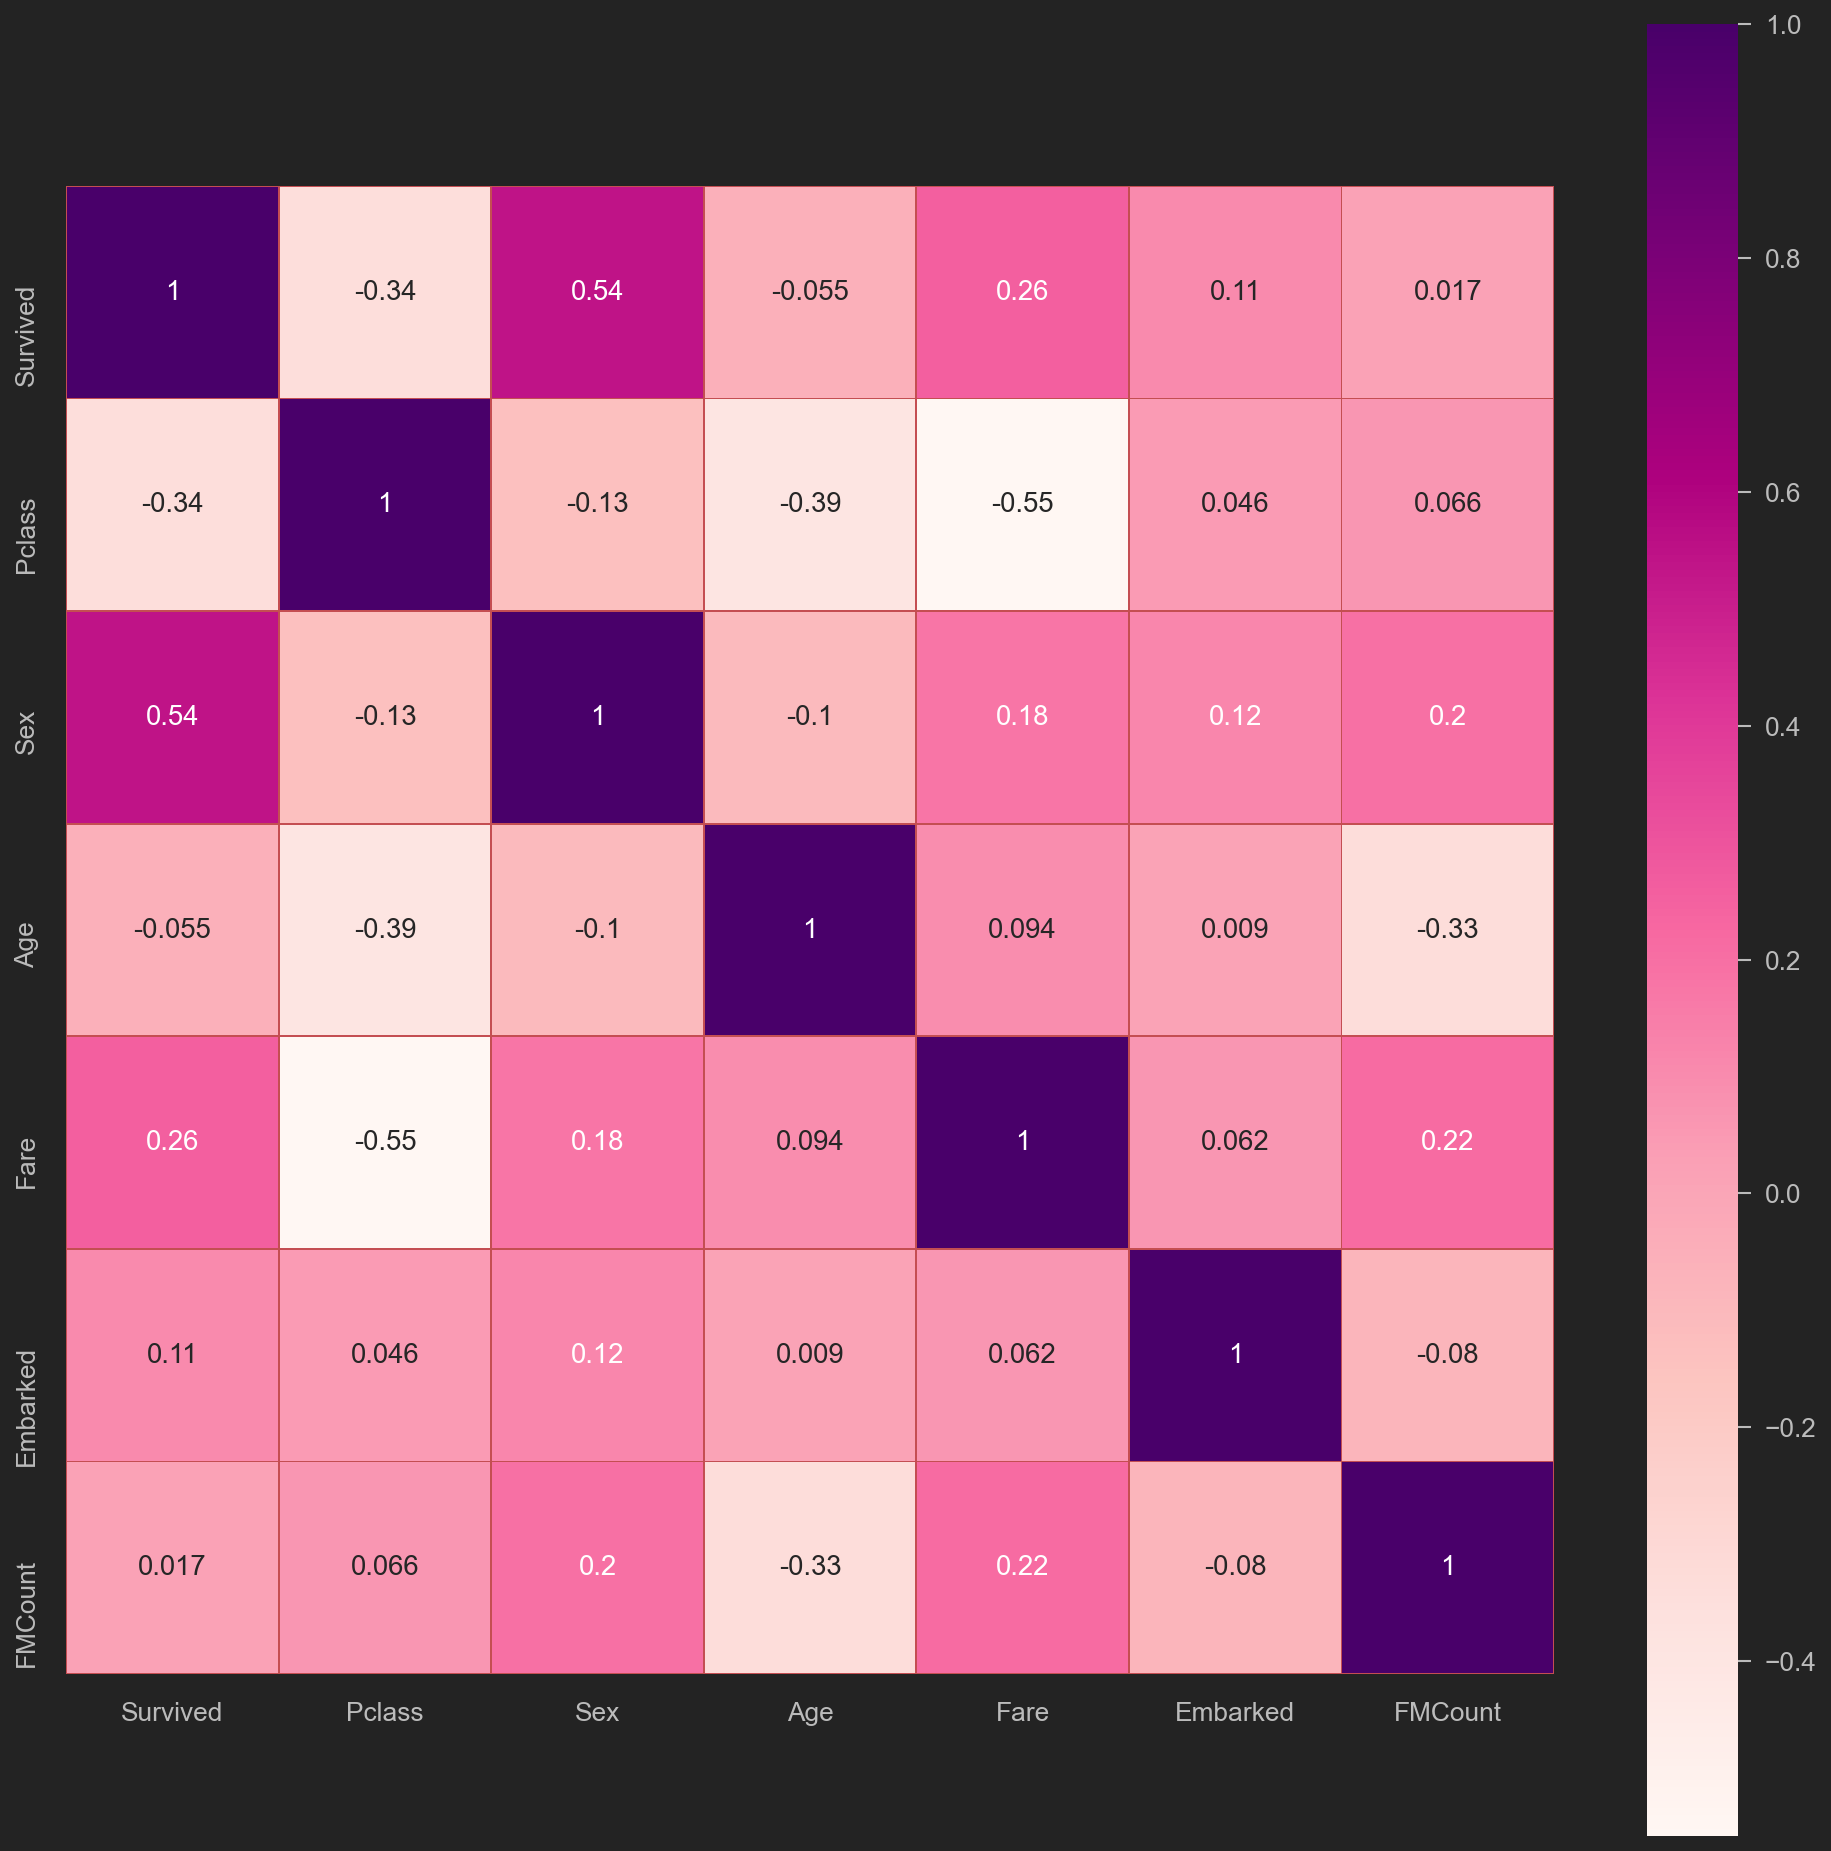

In [28]:
plt.figure(figsize=(16, 16))
sns.heatmap(heatMapData.astype(float).corr(),linewidths=.4, 
            square=True, linecolor='r', annot=True, cmap="RdPu")

## 尝试进行训练拟合

In [29]:
xTrain = heatMapData.drop('Survived', axis=1)
yTrain = heatMapData['Survived']
testData = pd.read_csv('./titanic/test.csv')
xTrain.info()
testData.info()
testData.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    int64  
 2   Age       891 non-null    float64
 3   Fare      891 non-null    float64
 4   Embarked  891 non-null    float64
 5   FMCount   891 non-null    int64  
dtypes: float64(3), int64(3)
memory usage: 41.9 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Far

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


**可以观察到, 测试数据并不是训练数据的子集, 测试数据来源有别于训练数据中的891位乘客, 而是另外418位乘客**

因为训练数据与测试数据有明显的字段差异(因在上文中, 对年龄的空缺值做了随机森林回归, 以及去除了无用字段). 

为保证训练能正常进行, `xTrain`要与`testData`即->`xTest`进行同样的处理


In [30]:
# 重复上文处理
testData.Fare.fillna(testData['Fare'].mean(), inplace=True)
age_df = testData[['Age', 'Fare', 'Parch', 'SibSp', 'Pclass']]
age_df_notnull = age_df.loc[(testData['Age'].notnull())]
age_df_isnull = age_df.loc[(testData['Age'].isnull())]
X = age_df_notnull.values[:,1:]
Y = age_df_notnull.values[:,0]
RFR = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
RFR.fit(X,Y)
predictAges = RFR.predict(age_df_isnull.values[:,1:])
testData.loc[testData['Age'].isnull(), ['Age']]= predictAges

testData['FMCount'] = testData['Parch'] + testData['SibSp'] + 1
testData.drop(['Name','Ticket','Cabin','PassengerId', 'SibSp', 'Parch'], 1, inplace=True)
testData.Sex.replace(('male','female'), (0,1), inplace = True)
testData.Embarked.replace(('S','C','Q'), (1,2,3), inplace = True)
testData.Embarked.fillna(1, inplace=True)
xTest = testData.copy()
xTrain.info()
xTest.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    int64  
 2   Age       891 non-null    float64
 3   Fare      891 non-null    float64
 4   Embarked  891 non-null    float64
 5   FMCount   891 non-null    int64  
dtypes: float64(3), int64(3)
memory usage: 41.9 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    int64  
 2   Age       418 non-null    float64
 3   Fare      418 non-null    float64
 4   Embarked  418 non-null    int64  
 5   FMCount   418 non-null    int64  
dtypes: float64(2), int64(4)
memory usage: 19.7 KB


可以看到训练数据与测试数据字段已经一致, 并且无空值.

引入`RandomForestClassifier`进行数据拟合.
> 即根据前891名乘客的存活情况来预测余下418位乘客的存活情况

In [31]:
# 训练数据头
print('Training Data Head 5')
xTrain.head(5)

Training Data Head 5


,Pclass,Sex,Age,Fare,Embarked,FMCount
0,3,0,22.0,7.2500,1.0,2
1,1,1,38.0,71.2833,2.0,2
2,3,1,26.0,7.9250,1.0,1
3,1,1,35.0,53.1000,1.0,2
4,3,0,35.0,8.0500,1.0,1


In [32]:
# 测试数据头
print('Testing Data Head 5')
xTest.head(5)

Testing Data Head 5


,Pclass,Sex,Age,Fare,Embarked,FMCount
0,3,0,34.5,7.8292,3,1
1,3,1,47.0,7.0000,1,2
2,2,0,62.0,9.6875,3,1
3,3,0,27.0,8.6625,1,1
4,3,1,22.0,12.2875,1,3


### `Linear Support Vector Classification`
> 支持向量机分类

In [33]:
SVC = LinearSVC()
SVC.fit(xTrain, yTrain)
yPredict = SVC.predict(xTest)
predPercentage = SVC.score(xTrain, yTrain)
print('Linear SVC Score')
print(round(predPercentage*100, 4))

Linear SVC Score
68.9113


c:\dev\env\py38venv\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


### `Random Forest`
> 随机森林预测

In [34]:
randomForest = RandomForestClassifier(n_estimators=300)
randomForest.fit(xTrain, yTrain)
yPredict = randomForest.predict(xTest)
predPercentage = randomForest.score(xTrain, yTrain)
print('Random Forest Score')
print(round(predPercentage*100, 4))

Random Forest Score
98.2043


### Decision Tree

> 决策树预测

In [35]:
decisionTree = DecisionTreeClassifier()
decisionTree.fit(xTrain, yTrain)  
yPredict = decisionTree.predict(xTest)  
predPercentage = decisionTree.score(xTrain, yTrain)
print('Decision Tree Score')
print(round(predPercentage*100, 4))

Decision Tree Score
98.2043
